# DNN: Comparative Study on CIFAR-10

## Briefer

|            |          |                      |
|------------|----------|----------------------|
| Subject    |          | Deep Neural Networks |
| Supervisor |          | Prof. Dinesh Babu J  |
|            |          |                      |
| Team Name  |          |                      |
| Member 1   | Name:    | Shreya Gupta         |
|            | Roll No: | MT2025724            |
| Member 2   | Name:    | Vibhuti Jain         |
|            | Roll No: | MT2025731            |
| Member 3   | Name:    | Anirudh Sharma       |
|            | Roll No: | MT2025732            |
|            |          |                      |

**Keywords:** NN, CNN, Activations, Optimisers, CIFAR-10

<!--
## Summary

* 4–8 bullet points summarizing highest-level conclusions (best model(s), tradeoffs, recommended next steps).
* Short comparative table of winners by criteria (accuracy, latency, model size, fairness, etc.)

## Introduction

* Problem statement and motivation
* Objectives of the comparative study (what questions you will answer)
* Scope (datasets, model families, compute constraints)
* Contributions (what unique analyses you provide - e.g., timing, memory profiling, calibration, fairness tests)
-->

## System Imports

In [1]:
!pip install -q chime joblib pandas numpy scipy scikit-learn matplotlib seaborn tqdm ipython torch torchvision torchaudio torchmetrics

In [1]:
import chime
import os, random, time, json
import functools, itertools
import warnings, joblib, inspect

import pandas as pd, numpy as np, scipy as sp
import sklearn as skl
import matplotlib as mpl, matplotlib.pyplot as plt, seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as tutils
import torch.utils.benchmark as tben
import torch.nn.functional as F
import torch.profiler as profiler
import torchvision

from tqdm import tqdm
import IPython.display as d

root_dir = ""

try:
    from google.colab import drive

    drive.mount('/content/drive')
    root_dir = "drive/MyDrive/dnn/prj1/"
except:
    pass

## Project Space Setup

### Notification System Setup

In [3]:
chime.theme("material")
chime.info()

### Functional Setup

In [4]:
for working_directory in ["curated_submissions", "dumps", "report/figures", "saves",
                          "report/sections", "report/settings", "report/tables", "submissions"]:
    os.makedirs(root_dir + working_directory, exist_ok=True)


# Optional<Function<Arg|Map, Unit>>
def compose(function, data_1, data_2: dict):
    if data_1 is not None:
        if isinstance(data_1, str):
            function(data_1, **data_2)
        elif isinstance(data_1, dict):
            data_2 = data_2.copy()
            data_2.update(data_1)
            function(**data_2)

### Graph Plotting System Setup

In [5]:
# Font Setup
font_suptitle = {'fontsize': 18, 'fontweight': "bold"}
font_title = {'fontsize': 14, 'fontweight': "bold"}
font_label = {'fontsize': 12}
font_ticks = {'fontsize': 10}

mpl.rcParams['font.family'] = 'monospace'
mpl.rcParams['axes.labelsize'] = font_label['fontsize']
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = font_ticks['fontsize']
mpl.rcParams['figure.titlesize'] = font_suptitle['fontsize']

max_fig_width = 11
sml_fig = (4, 3)
wid_fig = (8, 3)


# Font Embed Helpers
def annotate_plot(
        ax: plt.Axes,
        title: str = None,
        x_label: str = None, y_label: str = None,
        x_ticks=None, y_ticks=None,
) -> None:
    compose(ax.set_title, title, font_title)
    compose(ax.set_xlabel, x_label, font_label)
    compose(ax.set_ylabel, y_label, font_label)
    compose(ax.set_xticks, x_ticks, font_ticks)
    compose(ax.set_yticks, y_ticks, font_ticks)


def conclude_plot(
        suptitle: str = None,
        title: str = None,
        x_label: str = None, y_label: str = None,
        x_ticks=None, y_ticks=None,
        constrained=False):
    file_name = suptitle or title
    file_name = file_name.replace(':', '_').replace('/', '_')

    compose(plt.xlabel, x_label, font_label)
    compose(plt.ylabel, y_label, font_label)
    compose(plt.xticks, x_ticks, font_ticks)
    compose(plt.yticks, y_ticks, font_ticks)

    if constrained:
        fig.set_constrained_layout(True)
    else:
        plt.tight_layout()

    plt.savefig(root_dir + f'report/figures/plot_{file_name}.png', dpi=300)

    compose(plt.suptitle, suptitle, font_suptitle)
    compose(plt.title, title, font_title)

    if constrained:
        fig.set_constrained_layout(True)
    else:
        plt.tight_layout()

    plt.show()


def conclude_csv(ds: pd.DataFrame, name=None, index=False, transpose=False):
    if name is None:
        if isinstance(ds, pd.Series):
            name = ds.name
        else:
            raise NameError()
    ds = ds.copy()
    if transpose: ds = ds.transpose()
    ds = ds.round(2)
    ds.to_csv(root_dir + f'report/tables/data_{name}.csv', index=index, encoding="utf-8")


def plot(ax: plt.Axes, data, title, density=150):
    if len(data) > density:
        data = data[::(len(data) // density)]
    ax.plot(data)
    ax.set_title(title)
    if 'Accuracy' in title:
        ax.set_ylim(0, 1)


def historical_nomenclature(history):
    return str(history['parameters']).replace("'", "").replace(":", "=").replace(" ", "")


def prepare_report(history):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

    plot(axs[0][0], history['train_loss'], "Train Loss")
    plot(axs[0][1], history['val_loss'], "Validation Loss")
    plot(axs[1][0], history['train_acc'], "Train Accuracy")
    plot(axs[1][1], history['val_acc'], "Validation Accuracy")

    params = history['parameters']
    params['Total Time'] = "%4.2f sec" % history['total_time']
    key_length = max([len(k) for k in params.keys()]) + 1
    val_length = max([len(str(v)) for v in params.values()])
    metadata = "\n".join([f"%-{key_length}s: %-{val_length}s" % (k, v) for k, v in params.items()])
    fig.suptitle("Training Report", x=0.05, y=1, ha='left', **font_title)
    fig.text(0.95, 1, metadata, ha="right", va="top", **font_label)

    fig.tight_layout(rect=[0, 0, 1, 0.8])
    file_name = historical_nomenclature(history)
    plt.savefig(root_dir + f'report/figures/plot_{file_name}.png', dpi=300)
    plt.show()


chime.info()

### Randomizer System Setup

In [6]:
default_seed = 1114
current_seed = default_seed


def reset_seed(seed=default_seed):
    global current_seed
    current_seed = seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if hasattr(torch, "cuda"):
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


reset_seed()
chime.info()

### Presentation System Setup

In [7]:
markdown = lambda *x: display(d.Markdown(" ".join(x)))

subsection = lambda x: markdown(f"### {x}")
statement = lambda x: markdown(f"#### {x}")
quote = lambda field: markdown("\n\n> %s" % field.strip().replace("\n", "<br>"))
list_out = lambda t, l: statement("%s\n\n* %s" % (t, "\n* ".join(map(str, l))))
tab_out = lambda t: markdown(f"""
| {" | ".join(t.columns)} |
| {" | ".join("-" * len(t.columns))} |
{"\n".join([f"| {" | ".join(map(str, r))} |" for r in t.iloc])}
""")

kv = lambda field, value: "**%s:** `%s`" % (field.strip(), str(value).strip())

### Modelling System Setup

In [335]:
def save_history(history: dict, title=None):
    title = title or historical_nomenclature(history)
    print("Saving history to", title)
    model = history['model']
    history = {k: v for k, v in history.items() if k not in ['model', 'optimizer']}
    with open(root_dir + f"saves/history_{title}.json", "w") as f:
        json.dump(history, f, indent=2)
    torch.save(model.state_dict(), root_dir + f"saves/model_{title}.pth")


def load_history(title, include_model=True):
    with open(root_dir + f"saves/history_{title}.json", "r") as f:
        history = json.load(f)
    parameters = history['parameters']
    parameters['activation'] = getattr(nn, parameters['activation'])
    if include_model:
        model = model_step(
            int(parameters['conv_count']),
            int(parameters['fc_count']),
            parameters['activation'],
            10, 'cpu')
        model.load_state_dict(torch.load(root_dir + f"saves/model_{title}.pth"))
        history['model'] = model
    return history

## Data Loading and Description

In [9]:
%time

ds_train = torchvision.datasets.cifar.CIFAR10(root='../../data', download=True)
ds_test = torchvision.datasets.cifar.CIFAR10(train=False, root='../../data', download=True)

display(", ".join([x for x in dir(ds_train) if not x.startswith('_')]))

CPU times: total: 0 ns
Wall time: 0 ns


'base_folder, class_to_idx, classes, data, download, extra_repr, filename, meta, root, target_transform, targets, test_list, tgz_md5, train, train_list, transform, transforms, url'

In [10]:
ds_class_to_idx = pd.DataFrame(data=[*ds_train.class_to_idx.items()], columns=["Class Name", "Class ID"])
tab_out(ds_class_to_idx)


| Class Name | Class ID |
| - | - |
| airplane | 0 |
| automobile | 1 |
| bird | 2 |
| cat | 3 |
| deer | 4 |
| dog | 5 |
| frog | 6 |
| horse | 7 |
| ship | 8 |
| truck | 9 |


In [11]:
# Analyze basic data shape - input features and target column

data_shape = ds_train.data.shape
n_samples = data_shape[0]
n_features = np.prod(data_shape[1:])
n_targets = len(ds_train.classes)

statement(kv('Number of total samples', n_samples))
statement(kv('Number of features', n_features))
statement(kv('Number of classes in target feature', n_targets))

#### **Number of total samples:** `50000`

#### **Number of features:** `3072`

#### **Number of classes in target feature:** `10`

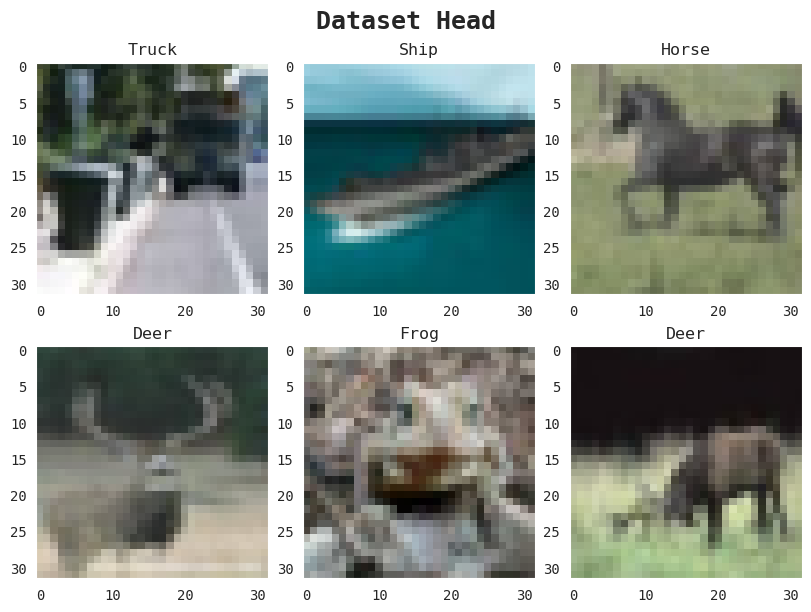

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(wid_fig[0], 6))
idxs = np.random.choice(n_samples, size=6, replace=False)
for idx, ax in zip(idxs, axs.flatten()):
    ax.imshow(ds_train.data[idx])
    ax.set_title(ds_train.classes[ds_train.targets[idx]].title())
    ax.grid(False)

conclude_plot("Dataset Head", constrained=True)

### Data Meta

In [13]:
statement(kv("Data Type", ds_train.data.dtype))
statement(kv("Max Value", np.max(ds_train.data)))
statement(kv("Min Value", np.min(ds_train.data)))

#### **Data Type:** `uint8`

#### **Max Value:** `255`

#### **Min Value:** `0`

### Class Distribution

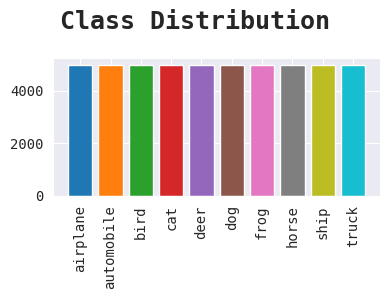

In [14]:
plt.figure(figsize=sml_fig)
_feat_uniques, _feat_counts = np.unique(ds_train.targets, return_counts=True)
for _uniq, _cnt in zip(_feat_uniques, _feat_counts):
    plt.bar(_uniq, _cnt)
plt.xticks(_feat_uniques, ds_train.classes)
plt.tick_params(axis='x', labelrotation=90)
conclude_plot("Class Distribution")

### Feature Meta

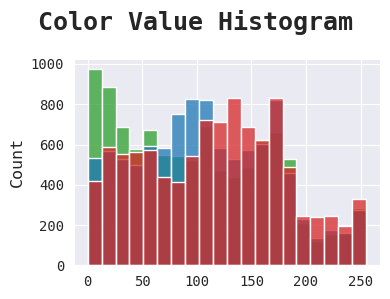

In [15]:
plt.figure(figsize=sml_fig)
sns.histplot(ds_train.data[::5000, :, :, 2].flatten(), label="Blue", color="#2ca02c", bins=20)
sns.histplot(ds_train.data[::5000, :, :, 1].flatten(), label="Green", color="#1f77b4", bins=20)
sns.histplot(ds_train.data[::5000, :, :, 0].flatten(), label="Red", color="#d62728", bins=20)
conclude_plot("Color Value Histogram")

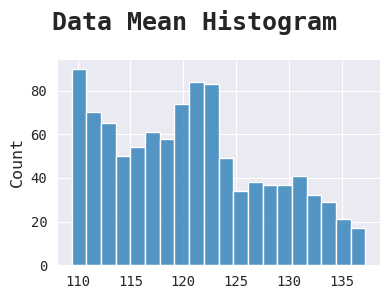

In [16]:
plt.figure(figsize=sml_fig)
ds_features_mean = np.mean(ds_train.data, axis=(0, 3)).flatten()
sns.histplot(ds_features_mean, bins=20)
conclude_plot("Data Mean Histogram")

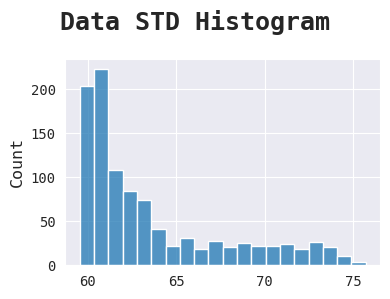

In [17]:
plt.figure(figsize=sml_fig)
ds_std = np.std(ds_train.data, axis=(0, 3)).flatten()
sns.histplot(ds_std, bins=20)
conclude_plot("Data STD Histogram")

### Missing Values

In [18]:
missing_count = np.sum(np.isnan(ds_train.data))
statement(kv("Number of samples with invalid state", missing_count))

#### **Number of samples with invalid state:** `0`

### Duplicate Counts

In [19]:
_ds_flat = ds_train.data.reshape(n_samples, -1)
_ds_bytes = np.ascontiguousarray(_ds_flat).view(np.dtype((np.void, _ds_flat.dtype.itemsize * _ds_flat.shape[1])))

duplicate_count = np.unique(_ds_bytes, return_counts=True)[1]
duplicate_count = np.sum(duplicate_count > 1)

statement(kv("Number of duplicated samples", duplicate_count))

#### **Number of duplicated samples:** `0`

### Outlier Detection

In [20]:
statement(kv("Invalid PIxels", np.sum(np.isnan(ds_train.data).any(axis=(0, 1, 2, 3)))))
statement(kv("Blank Images", np.sum(np.all(ds_train.data == 0, axis=(1, 2, 3)))))
ds_images_mean = np.mean(ds_train.data, axis=(1, 2, 3))
statement(kv("Over Exposed", np.sum(ds_images_mean > 256 * 0.9)))
statement(kv("Under Exposed", np.sum(ds_images_mean < 256 * 0.1)))

#### **Invalid PIxels:** `0`

#### **Blank Images:** `0`

#### **Over Exposed:** `43`

#### **Under Exposed:** `32`

## Data Modelling

### Re-Shaping for PyTorch

In [21]:
ds_train.data = np.transpose(ds_train.data, (0, 3, 1, 2))
ds_test.data = np.transpose(ds_test.data, (0, 3, 1, 2))

statement(kv("Data Shape", ds_train.data.shape))

#### **Data Shape:** `(50000, 3, 32, 32)`

### Data Scaling
Since we are applying a fixed scale of [0, 1], we do not need to scale train (fit) and test (tr) separately.

In [22]:
ds_train.data = (ds_train.data / 255).astype(np.float16)
ds_test.data = (ds_test.data / 255).astype(np.float16)

statement(kv("Data Shape", ds_train.data.shape))

#### **Data Shape:** `(50000, 3, 32, 32)`

### Train-Validation Split

In [23]:
reset_seed()

train_x, val_x, train_y, val_y = skl.model_selection.train_test_split \
    (ds_train.data, ds_train.targets, test_size=5000,
     random_state=current_seed, stratify=ds_train.targets)

statement(kv("Train Set Size", len(train_x)))
statement(kv("Val Set Size", len(val_x)))
statement(kv("Test Set Size", len(ds_test.data)))

#### **Train Set Size:** `45000`

#### **Val Set Size:** `5000`

#### **Test Set Size:** `10000`

In [24]:
def data_step(device):
    if isinstance(device, str):
        device = torch.device(device)

    tensor_train_x = torch.tensor(train_x, dtype=torch.float32, device=device)
    tensor_train_y = torch.tensor(train_y, dtype=torch.long, device=device)
    tensor_val_x = torch.tensor(val_x, dtype=torch.float32, device=device)
    tensor_val_y = torch.tensor(val_y, dtype=torch.long, device=device)
    tensor_test_x = torch.tensor(ds_test.data, dtype=torch.float32, device=device)
    tensor_test_y = torch.tensor(ds_test.targets, dtype=torch.long, device=device)

    dataset_train = tutils.data.TensorDataset(tensor_train_x, tensor_train_y)
    dataset_val = tutils.data.TensorDataset(tensor_val_x, tensor_val_y)
    dataset_test = tutils.data.TensorDataset(tensor_test_x, tensor_test_y)

    return dataset_train, dataset_val, dataset_test

In [25]:
def batch_step(batch_size, num_workers, *datasets):
    dataset_train, dataset_val, dataset_test = datasets
    reset_seed()

    if batch_size is None:
        batch_size = len(dataset_train)

    loader_train = tutils.data.DataLoader \
        (dataset_train, batch_size=batch_size,
         shuffle=True, num_workers=num_workers)
    loader_val = tutils.data.DataLoader \
        (dataset_val, batch_size=len(dataset_val),
         shuffle=False, )
    loader_test = tutils.data.DataLoader \
        (dataset_test, batch_size=len(dataset_test),
         shuffle=False, )  # pin_memory=True

    return loader_train, loader_val, loader_test

In [313]:
def model_step(n_convs, n_fcs, i_act, n_cls, device):
    class Model(nn.Module):
        def __init__(self):
            super(Model, self).__init__()
            layers = []

            layers.append(nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1, device=device))
            layers.append(i_act())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

            for i in range(n_convs - 1):
                layers.append(nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1, device=device))
                layers.append(i_act())
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

            layers.append(nn.Flatten())
            _flat_in = (32 * 32 * 32) // ((2 ** n_convs) ** 2)
            #           w    h    c        2    n           wxh
            layers.append(nn.Linear(_flat_in, 1024, device=device))
            layers.append(i_act())

            for i in range(n_fcs - 2):
                layers.append(nn.Linear(1024, 1024, device=device))
                layers.append(i_act())

            layers.append(nn.Linear(1024, n_cls, device=device))

            for index, layer in enumerate(layers):
                setattr(self, 'layer{}'.format(index), layer)
            self.layers = layers

        def forward(self, x):
            for layer in self.layers:
                x = layer(x)
            # Generally, there is no need to apply softmax here, since Cross Entropy automatically considers and optimizes on the logits
            # return F.softmax(layers[-1](x), dim=1)
            return x

    return Model()

In [314]:
def set_learning_rate(optimizer, learning_rate):
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate


def optimizer_step(optim_strategy, learning_rate, model):
    if optim_strategy is None:
        return optim.SGD(params=model.parameters(), lr=learning_rate)
    if optim_strategy == 'Momentum':
        return optim.SGD(params=model.parameters(), lr=learning_rate, momentum=0.9)
    if optim_strategy == 'AdaptiveLR':
        return optim.RMSprop(params=model.parameters(), lr=learning_rate, alpha=0.99)
    if optim_strategy == 'Both':
        return optim.Adam(params=model.parameters(), lr=learning_rate, betas=(0.9, 0.99))
    return None

In [315]:
def train_step(
        model, loaders, criterion, optimizer,
        learning_rate, label, limit):
    start_time = tben.timer()

    model.train()
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []

    loader_train, loader_val, _ = loaders

    skip_batches = 1
    no_of_batches = len(loader_train)
    if no_of_batches > 100:
        skip_batches = no_of_batches // 100

    set_learning_rate(optimizer, learning_rate)

    with (tqdm(total=no_of_batches) as pbar):
        for batch, (x_batch, y_batch) in enumerate(loader_train):
            if limit is not None and batch >= limit:
                break

            p_batch = model(x_batch)  # Predictions
            loss = criterion(p_batch, y_batch)
            train_loss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            c_batch = torch.argmax(torch.softmax(p_batch, dim=1), dim=1)  # Classes
            train_acc.append((c_batch == y_batch).sum().item() / len(y_batch))

            pbar.desc = f"%s [Train] Loss: %9.6f Accuracy: %7.6f" % \
                        (label, train_loss[-1], train_acc[-1])
            pbar.update(1)

            if batch == 0 or (batch - 1) % skip_batches == 0:
                model.eval()

                with torch.no_grad():
                    x_batch, y_batch = next(iter(loader_val))
                    p_batch = model(x_batch)
                    loss = criterion(p_batch, y_batch)
                    val_loss.append(loss.item())

                    c_batch = torch.argmax(torch.softmax(p_batch, dim=1), dim=1)  # Classes
                    val_acc.append((c_batch == y_batch).sum().item() / len(y_batch))

                model.train()

        print("Speed %.2f it/s" % pbar.format_dict["rate"])

    return {'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss,
            'val_acc': val_acc, 'total_time': tben.timer() - start_time}

In [333]:
def run_experiment(
        conv_count, fc_count, activation,
        batch_size, num_workers,
        optim_strategy,
        learning_rate,
        device, model=None,
        epochs=1, limit=None,
        histories=None,
):
    criterion = nn.CrossEntropyLoss()
    datasets = data_step(device)
    loaders = batch_step(batch_size, num_workers, *datasets)
    model = (model or model_step(conv_count, fc_count, activation, 10, device)).to(device)
    optimizer = optimizer_step(optim_strategy, learning_rate, model)
    if histories is not None:
        histories['parameters']['epochs'] = int(histories['parameters']['epochs']) + epochs
        optimizer = histories['optimizer']
    histories = histories or {
        'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'total_time': 0,
        'parameters': {'conv_count': str(conv_count), 'fc_count': str(fc_count), 'activation': activation.__name__,
                       'batch_size': str(batch_size), 'optim_strategy': str(optim_strategy),
                       'learning_rate': str(learning_rate), 'epochs': epochs},
        'model': model,
        'optimizer': optimizer,
    }
    for epoch in range(epochs):
        label = f"Epoch {epoch + 1}/{epochs}"
        history = train_step(model, loaders, criterion, optimizer,
                             learning_rate, label, limit)
        for aspect in ['train_loss', 'train_acc', 'val_loss', 'val_acc']:
            histories[aspect].extend(history[aspect])
        histories['total_time'] += history['total_time']
    return histories

Epoch 1/1 [Train] Loss:  2.047747 Accuracy: 0.209711: 100%|██████████| 44/44 [00:04<00:00,  9.02it/s]


Speed 9.88 it/s


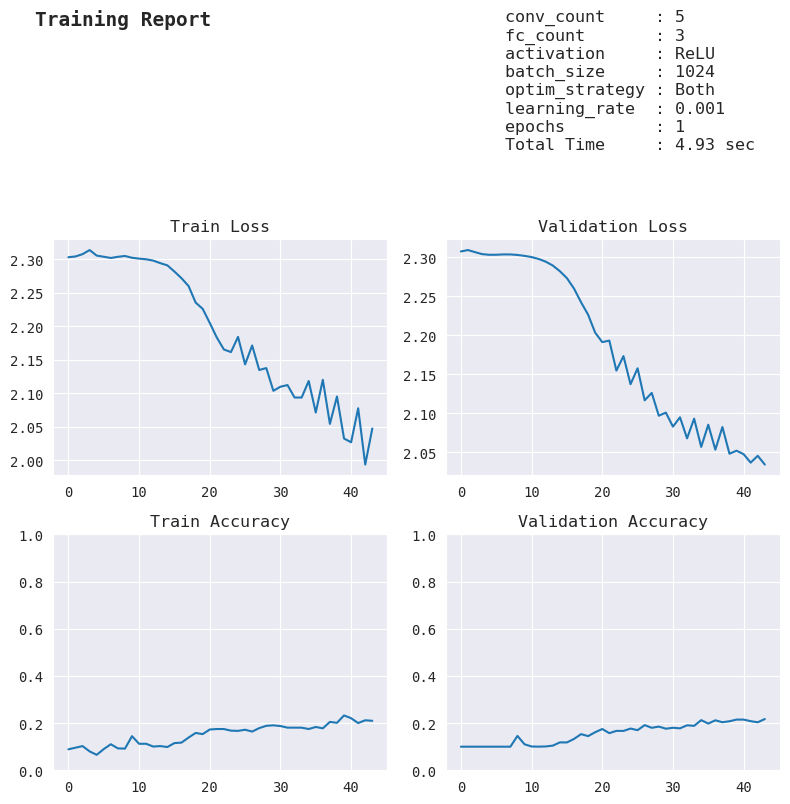

Saving history to {conv_count=5,fc_count=3,activation=ReLU,batch_size=1024,optim_strategy=Both,learning_rate=0.001,epochs=1,TotalTime=4.93sec}


In [344]:
# # 5.67 s/it on colab cpu | # 1.59 it/s on local cpu
# # 5.69 1t/s on colab gpu | # 10.5 1t/s on local gpu
# # ??? on xla ( Unabel to run :( )
history = run_experiment(
    # conv_count=2, fc_count=4, activation=nn.ReLU,
    conv_count=5, fc_count=3, activation=nn.ReLU,
    batch_size=1024, num_workers=0,
    optim_strategy="Both",
    learning_rate=0.001,
    device='cuda',  # 'cpu', 'cuda', 'xla'
    epochs=1, limit=None,
)
prepare_report(history)
save_history(history)
chime.info()

Epoch 1/30 [Train] Loss:  0.241872 Accuracy: 0.916322: 100%|██████████| 44/44 [00:05<00:00,  8.41it/s]


Speed 8.65 it/s


Epoch 2/30 [Train] Loss:  0.246000 Accuracy: 0.915289: 100%|██████████| 44/44 [00:04<00:00,  9.47it/s]


Speed 10.53 it/s


Epoch 3/30 [Train] Loss:  0.242721 Accuracy: 0.909091: 100%|██████████| 44/44 [00:05<00:00,  8.56it/s]


Speed 7.57 it/s


Epoch 4/30 [Train] Loss:  0.288458 Accuracy: 0.901860: 100%|██████████| 44/44 [00:04<00:00,  9.44it/s]


Speed 10.13 it/s


Epoch 5/30 [Train] Loss:  0.265754 Accuracy: 0.908058: 100%|██████████| 44/44 [00:05<00:00,  8.51it/s]


Speed 6.65 it/s


Epoch 6/30 [Train] Loss:  0.225412 Accuracy: 0.914256: 100%|██████████| 44/44 [00:04<00:00,  9.48it/s]


Speed 10.07 it/s


Epoch 7/30 [Train] Loss:  0.260016 Accuracy: 0.907025: 100%|██████████| 44/44 [00:05<00:00,  8.56it/s]


Speed 10.53 it/s


Epoch 8/30 [Train] Loss:  0.237906 Accuracy: 0.914256: 100%|██████████| 44/44 [00:04<00:00,  9.55it/s]


Speed 9.83 it/s


Epoch 9/30 [Train] Loss:  0.290662 Accuracy: 0.893595: 100%|██████████| 44/44 [00:04<00:00,  9.46it/s]


Speed 10.52 it/s


Epoch 10/30 [Train] Loss:  0.221321 Accuracy: 0.922521: 100%|██████████| 44/44 [00:05<00:00,  8.67it/s]


Speed 9.49 it/s


Epoch 11/30 [Train] Loss:  0.218188 Accuracy: 0.924587: 100%|██████████| 44/44 [00:04<00:00,  9.52it/s]


Speed 10.36 it/s


Epoch 12/30 [Train] Loss:  0.191981 Accuracy: 0.940083: 100%|██████████| 44/44 [00:05<00:00,  8.60it/s]


Speed 8.26 it/s


Epoch 13/30 [Train] Loss:  0.267012 Accuracy: 0.901860: 100%|██████████| 44/44 [00:04<00:00,  9.70it/s]


Speed 10.55 it/s


Epoch 14/30 [Train] Loss:  0.231195 Accuracy: 0.912190: 100%|██████████| 44/44 [00:05<00:00,  8.54it/s]


Speed 6.63 it/s


Epoch 15/30 [Train] Loss:  0.207740 Accuracy: 0.916322: 100%|██████████| 44/44 [00:04<00:00,  9.56it/s]


Speed 10.65 it/s


Epoch 16/30 [Train] Loss:  0.206892 Accuracy: 0.921488: 100%|██████████| 44/44 [00:05<00:00,  8.77it/s]


Speed 6.04 it/s


Epoch 17/30 [Train] Loss:  0.163121 Accuracy: 0.944215: 100%|██████████| 44/44 [00:04<00:00,  9.61it/s]


Speed 10.44 it/s


Epoch 18/30 [Train] Loss:  0.224875 Accuracy: 0.907025: 100%|██████████| 44/44 [00:04<00:00,  9.53it/s]


Speed 10.64 it/s


Epoch 19/30 [Train] Loss:  0.191112 Accuracy: 0.934917: 100%|██████████| 44/44 [00:05<00:00,  8.67it/s]


Speed 9.97 it/s


Epoch 20/30 [Train] Loss:  0.217978 Accuracy: 0.911157: 100%|██████████| 44/44 [00:04<00:00,  9.61it/s]


Speed 10.50 it/s


Epoch 21/30 [Train] Loss:  0.146111 Accuracy: 0.947314: 100%|██████████| 44/44 [00:05<00:00,  8.62it/s]


Speed 9.51 it/s


Epoch 22/30 [Train] Loss:  0.162686 Accuracy: 0.943182: 100%|██████████| 44/44 [00:04<00:00,  9.65it/s]


Speed 10.62 it/s


Epoch 23/30 [Train] Loss:  0.192517 Accuracy: 0.930785: 100%|██████████| 44/44 [00:05<00:00,  8.68it/s]


Speed 9.03 it/s


Epoch 24/30 [Train] Loss:  0.181578 Accuracy: 0.933884: 100%|██████████| 44/44 [00:04<00:00,  9.68it/s]


Speed 10.47 it/s


Epoch 25/30 [Train] Loss:  0.144149 Accuracy: 0.950413: 100%|██████████| 44/44 [00:05<00:00,  8.77it/s]


Speed 7.82 it/s


Epoch 26/30 [Train] Loss:  0.210510 Accuracy: 0.925620: 100%|██████████| 44/44 [00:04<00:00,  9.71it/s]


Speed 10.48 it/s


Epoch 27/30 [Train] Loss:  0.148168 Accuracy: 0.944215: 100%|██████████| 44/44 [00:05<00:00,  8.66it/s]


Speed 6.48 it/s


Epoch 28/30 [Train] Loss:  0.139977 Accuracy: 0.955579: 100%|██████████| 44/44 [00:04<00:00,  9.63it/s]


Speed 9.74 it/s


Epoch 29/30 [Train] Loss:  0.199209 Accuracy: 0.927686: 100%|██████████| 44/44 [00:05<00:00,  8.66it/s]


Speed 10.67 it/s


Epoch 30/30 [Train] Loss:  0.141680 Accuracy: 0.954545: 100%|██████████| 44/44 [00:04<00:00,  9.67it/s]


Speed 9.47 it/s


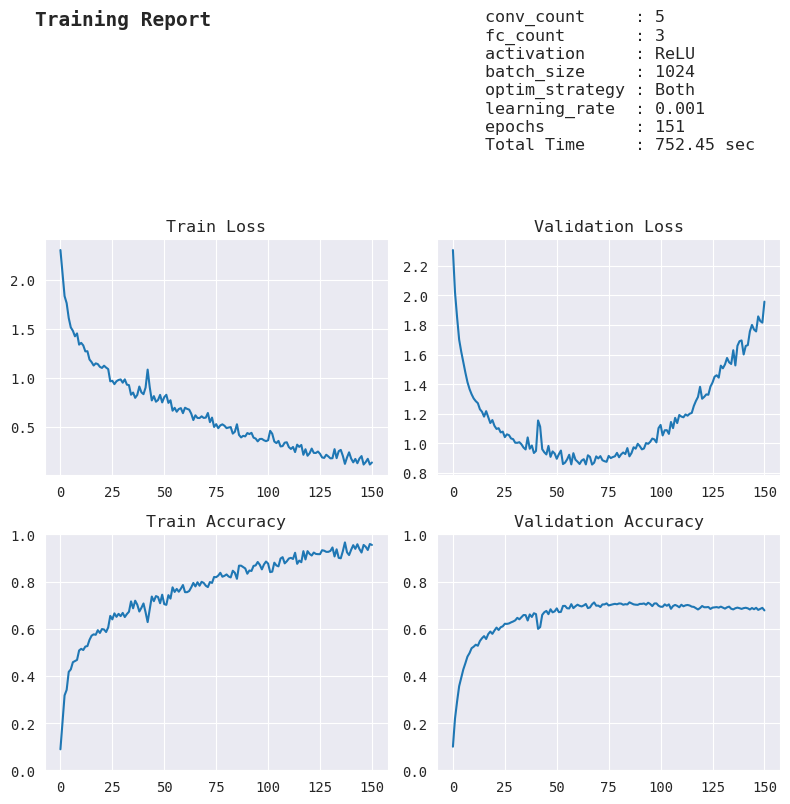

Saving history to {conv_count=5,fc_count=3,activation=ReLU,batch_size=1024,optim_strategy=Both,learning_rate=0.001,epochs=151,TotalTime=752.45sec}


In [353]:
history = run_experiment(
    # conv_count=2, fc_count=4, activation=nn.ReLU,
    conv_count=5, fc_count=3, activation=nn.ReLU,
    batch_size=1024, num_workers=0,
    optim_strategy='Both',
    learning_rate=0.002,
    device='cuda',  # 'cpu', 'cuda', 'xla'
    epochs=30, limit=None,
    model=history['model'],
    histories=history
)
prepare_report(history)
save_history(history)
chime.info()

In [ ]:
batch_size_to_history = {}
for batch_size in [1, 4, 16, 64, 256, 1024, 4096]:
    history = run_experiment(
        conv_count=2, fc_count=3, activation=nn.ReLU,
        batch_size=batch_size, num_workers=0,
        optim_strategy=None,
        learning_rate=0.031,
        device='cuda',
        epochs=1,
    )
    del history['model']
    batch_size_to_history[batch_size] = history

chime.success()

Epoch 1/1 [Train] Loss:  2.302585 Accuracy: 0.000000: 100%|██████████| 45000/45000 [01:56<00:00, 387.00it/s]
Epoch 1/1 [Train] Loss:  1.513376 Accuracy: 0.500000: 100%|██████████| 11250/11250 [00:37<00:00, 297.40it/s]
Epoch 1/1 [Train] Loss:  1.689998 Accuracy: 0.250000: 100%|██████████| 2813/2813 [00:17<00:00, 162.94it/s]
Epoch 1/1 [Train] Loss:  2.363323 Accuracy: 0.000000: 100%|██████████| 704/704 [00:12<00:00, 54.88it/s]
Epoch 1/1 [Train] Loss:  2.299562 Accuracy: 0.160000: 100%|██████████| 176/176 [00:20<00:00,  8.68it/s]
Epoch 1/1 [Train] Loss:  2.302337 Accuracy: 0.112603: 100%|██████████| 44/44 [00:05<00:00,  7.37it/s]
Epoch 1/1 [Train] Loss:  2.302469 Accuracy: 0.103960: 100%|██████████| 11/11 [00:03<00:00,  3.10it/s]


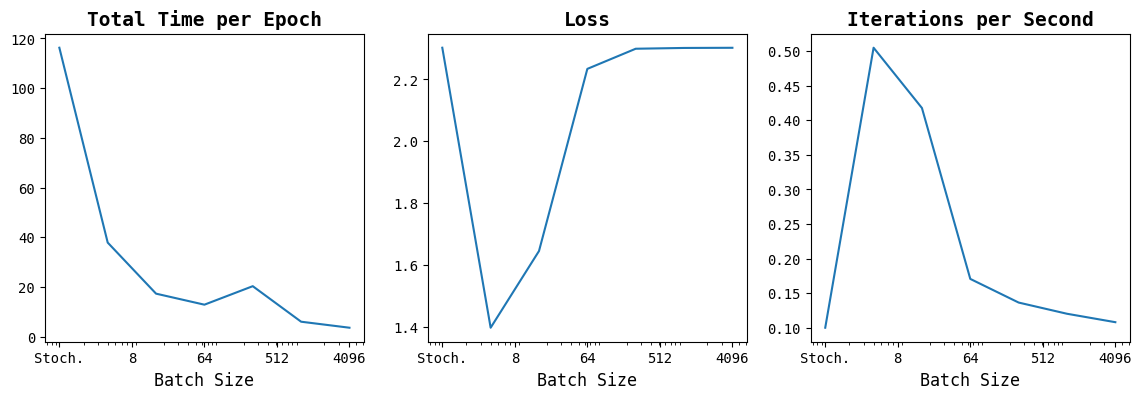

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
for ax, (title, data) in zip(axs, [
    ('Total Time per Epoch', [v['total_time'] for k, v in batch_size_to_history.items()]),
    ('Loss', [v['val_loss'][-1] for k, v in batch_size_to_history.items()]),
    ('Iterations per Second', [v['val_acc'][-1] for k, v in batch_size_to_history.items()])]):
    ax.set_title(title, **font_title)
    ax.plot([1, 4, 16, 64, 256, 1024, 4096], data)
    ax.set_xlabel('Batch Size', **font_label)
    ax.set_xscale('log')
    ax.set_xticks([1, 8, 64, 512, 4096], ['Stoch.', '8', '64', '512', '4096'])

plt.show()

In [30]:
# Kind of a grid search
perm_fc_count = [2, 3, 4, 5]
perm_conv_count = [2, 3, 4, 5]
perm_activations = [nn.ReLU, nn.Tanh, nn.Sigmoid]
perm_optimizations = [None, 'Momentum', 'AdaptiveLR', 'Both']

perm_history = {}

In [ ]:
if input(
        "Warning! This is a time consuming Grid Search! Last run took 4 hours to complete. Do you want to run it?") == "YES":
    for fc_count, conv_count, activation, optimization \
            in itertools.product(perm_fc_count, perm_conv_count,
                                 perm_activations, perm_optimizations):
        key = ", ".join([str(fc_count), str(conv_count), activation.__name__, str(optimization)])
        print(key)
        history = run_experiment(
            conv_count=conv_count, fc_count=fc_count, activation=activation,
            batch_size=4096, num_workers=0,
            optim_strategy=optimization,
            learning_rate=0.001,
            device='cuda',
            epochs=2,
        )

        perm_history[key] = history
        save_history(history, key)
        chime.info()

    chime.success()

Warning! This is a time consuming Grid Search! Last run took 4 hours to complete. Do you want to run it?YES
2, 2, ReLU, None


Epoch 1/2 [Train] Loss:  2.302100 Accuracy: 0.082178: 100%|██████████| 11/11 [00:02<00:00,  4.12it/s]
Epoch 2/2 [Train] Loss:  2.302804 Accuracy: 0.078218: 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]


Saving history to 2, 2, ReLU, None
2, 2, ReLU, Momentum


Epoch 1/2 [Train] Loss:  2.301958 Accuracy: 0.093317: 100%|██████████| 11/11 [00:02<00:00,  4.24it/s]
Epoch 2/2 [Train] Loss:  2.302310 Accuracy: 0.093564: 100%|██████████| 11/11 [00:02<00:00,  4.23it/s]


Saving history to 2, 2, ReLU, Momentum
2, 2, ReLU, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.295436 Accuracy: 0.117327: 100%|██████████| 11/11 [00:02<00:00,  4.42it/s]
Epoch 2/2 [Train] Loss:  2.266259 Accuracy: 0.134158: 100%|██████████| 11/11 [00:02<00:00,  3.96it/s]


Saving history to 2, 2, ReLU, AdaptiveLR
2, 2, ReLU, Both


Epoch 1/2 [Train] Loss:  2.190762 Accuracy: 0.256931: 100%|██████████| 11/11 [00:02<00:00,  4.04it/s]
Epoch 2/2 [Train] Loss:  2.105930 Accuracy: 0.266337: 100%|██████████| 11/11 [00:02<00:00,  4.21it/s]


Saving history to 2, 2, ReLU, Both
2, 2, Tanh, None


Epoch 1/2 [Train] Loss:  2.302754 Accuracy: 0.127723: 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]
Epoch 2/2 [Train] Loss:  2.304006 Accuracy: 0.118069: 100%|██████████| 11/11 [00:02<00:00,  4.57it/s]


Saving history to 2, 2, Tanh, None
2, 2, Tanh, Momentum


Epoch 1/2 [Train] Loss:  2.301674 Accuracy: 0.124752: 100%|██████████| 11/11 [00:03<00:00,  3.58it/s]
Epoch 2/2 [Train] Loss:  2.300322 Accuracy: 0.109158: 100%|██████████| 11/11 [00:02<00:00,  4.15it/s]


Saving history to 2, 2, Tanh, Momentum
2, 2, Tanh, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.672899 Accuracy: 0.101485: 100%|██████████| 11/11 [00:02<00:00,  4.50it/s]
Epoch 2/2 [Train] Loss:  2.457881 Accuracy: 0.098267: 100%|██████████| 11/11 [00:02<00:00,  4.24it/s]


Saving history to 2, 2, Tanh, AdaptiveLR
2, 2, Tanh, Both


Epoch 1/2 [Train] Loss:  1.977612 Accuracy: 0.346535: 100%|██████████| 11/11 [00:02<00:00,  3.81it/s]
Epoch 2/2 [Train] Loss:  1.857302 Accuracy: 0.379950: 100%|██████████| 11/11 [00:02<00:00,  3.96it/s]


Saving history to 2, 2, Tanh, Both
2, 2, Sigmoid, None


Epoch 1/2 [Train] Loss:  2.305406 Accuracy: 0.099752: 100%|██████████| 11/11 [00:02<00:00,  4.14it/s]
Epoch 2/2 [Train] Loss:  2.306198 Accuracy: 0.101238: 100%|██████████| 11/11 [00:02<00:00,  4.51it/s]


Saving history to 2, 2, Sigmoid, None
2, 2, Sigmoid, Momentum


Epoch 1/2 [Train] Loss:  2.305166 Accuracy: 0.099752: 100%|██████████| 11/11 [00:02<00:00,  3.85it/s]
Epoch 2/2 [Train] Loss:  2.305242 Accuracy: 0.101238: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s]


Saving history to 2, 2, Sigmoid, Momentum
2, 2, Sigmoid, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.336319 Accuracy: 0.093564: 100%|██████████| 11/11 [00:02<00:00,  4.50it/s]
Epoch 2/2 [Train] Loss:  2.302722 Accuracy: 0.101733: 100%|██████████| 11/11 [00:02<00:00,  4.21it/s]


Saving history to 2, 2, Sigmoid, AdaptiveLR
2, 2, Sigmoid, Both


Epoch 1/2 [Train] Loss:  2.302839 Accuracy: 0.106931: 100%|██████████| 11/11 [00:02<00:00,  4.52it/s]
Epoch 2/2 [Train] Loss:  2.302667 Accuracy: 0.101733: 100%|██████████| 11/11 [00:03<00:00,  3.44it/s]


Saving history to 2, 2, Sigmoid, Both
2, 3, ReLU, None


Epoch 1/2 [Train] Loss:  2.302476 Accuracy: 0.101980: 100%|██████████| 11/11 [00:02<00:00,  3.94it/s]
Epoch 2/2 [Train] Loss:  2.302495 Accuracy: 0.107921: 100%|██████████| 11/11 [00:02<00:00,  4.27it/s]


Saving history to 2, 3, ReLU, None
2, 3, ReLU, Momentum


Epoch 1/2 [Train] Loss:  2.302469 Accuracy: 0.102228: 100%|██████████| 11/11 [00:02<00:00,  3.97it/s]
Epoch 2/2 [Train] Loss:  2.302456 Accuracy: 0.118564: 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]


Saving history to 2, 3, ReLU, Momentum
2, 3, ReLU, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.302585 Accuracy: 0.102475: 100%|██████████| 11/11 [00:02<00:00,  3.98it/s]
Epoch 2/2 [Train] Loss:  2.302585 Accuracy: 0.094554: 100%|██████████| 11/11 [00:02<00:00,  4.01it/s]


Saving history to 2, 3, ReLU, AdaptiveLR
2, 3, ReLU, Both


Epoch 1/2 [Train] Loss:  2.279984 Accuracy: 0.102475: 100%|██████████| 11/11 [00:02<00:00,  4.27it/s]
Epoch 2/2 [Train] Loss:  2.267309 Accuracy: 0.156683: 100%|██████████| 11/11 [00:03<00:00,  3.61it/s]


Saving history to 2, 3, ReLU, Both
2, 3, Tanh, None


Epoch 1/2 [Train] Loss:  2.303164 Accuracy: 0.092822: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s]
Epoch 2/2 [Train] Loss:  2.303812 Accuracy: 0.095050: 100%|██████████| 11/11 [00:02<00:00,  4.24it/s]


Saving history to 2, 3, Tanh, None
2, 3, Tanh, Momentum


Epoch 1/2 [Train] Loss:  2.302967 Accuracy: 0.095050: 100%|██████████| 11/11 [00:02<00:00,  3.95it/s]
Epoch 2/2 [Train] Loss:  2.303102 Accuracy: 0.093069: 100%|██████████| 11/11 [00:02<00:00,  3.97it/s]


Saving history to 2, 3, Tanh, Momentum
2, 3, Tanh, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.732130 Accuracy: 0.094802: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]
Epoch 2/2 [Train] Loss:  2.661285 Accuracy: 0.104208: 100%|██████████| 11/11 [00:02<00:00,  3.93it/s]


Saving history to 2, 3, Tanh, AdaptiveLR
2, 3, Tanh, Both


Epoch 1/2 [Train] Loss:  2.018383 Accuracy: 0.302228: 100%|██████████| 11/11 [00:02<00:00,  4.21it/s]
Epoch 2/2 [Train] Loss:  1.930097 Accuracy: 0.304950: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s]


Saving history to 2, 3, Tanh, Both
2, 3, Sigmoid, None


Epoch 1/2 [Train] Loss:  2.304444 Accuracy: 0.103218: 100%|██████████| 11/11 [00:03<00:00,  3.56it/s]
Epoch 2/2 [Train] Loss:  2.306933 Accuracy: 0.099010: 100%|██████████| 11/11 [00:02<00:00,  4.25it/s]


Saving history to 2, 3, Sigmoid, None
2, 3, Sigmoid, Momentum


Epoch 1/2 [Train] Loss:  2.304253 Accuracy: 0.103218: 100%|██████████| 11/11 [00:02<00:00,  3.95it/s]
Epoch 2/2 [Train] Loss:  2.305847 Accuracy: 0.099010: 100%|██████████| 11/11 [00:02<00:00,  4.24it/s]


Saving history to 2, 3, Sigmoid, Momentum
2, 3, Sigmoid, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.310318 Accuracy: 0.099752: 100%|██████████| 11/11 [00:03<00:00,  3.40it/s]
Epoch 2/2 [Train] Loss:  2.303606 Accuracy: 0.099505: 100%|██████████| 11/11 [00:02<00:00,  3.91it/s]


Saving history to 2, 3, Sigmoid, AdaptiveLR
2, 3, Sigmoid, Both


Epoch 1/2 [Train] Loss:  2.305696 Accuracy: 0.099752: 100%|██████████| 11/11 [00:02<00:00,  4.24it/s]
Epoch 2/2 [Train] Loss:  2.305683 Accuracy: 0.094554: 100%|██████████| 11/11 [00:02<00:00,  3.91it/s]


Saving history to 2, 3, Sigmoid, Both
2, 4, ReLU, None


Epoch 1/2 [Train] Loss:  2.303008 Accuracy: 0.093564: 100%|██████████| 11/11 [00:03<00:00,  3.32it/s]
Epoch 2/2 [Train] Loss:  2.302837 Accuracy: 0.101733: 100%|██████████| 11/11 [00:02<00:00,  4.16it/s]


Saving history to 2, 4, ReLU, None
2, 4, ReLU, Momentum


Epoch 1/2 [Train] Loss:  2.303002 Accuracy: 0.093564: 100%|██████████| 11/11 [00:02<00:00,  3.87it/s]
Epoch 2/2 [Train] Loss:  2.302816 Accuracy: 0.101733: 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]


Saving history to 2, 4, ReLU, Momentum
2, 4, ReLU, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.302585 Accuracy: 0.102475: 100%|██████████| 11/11 [00:03<00:00,  3.26it/s]
Epoch 2/2 [Train] Loss:  2.302585 Accuracy: 0.094554: 100%|██████████| 11/11 [00:02<00:00,  3.88it/s]


Saving history to 2, 4, ReLU, AdaptiveLR
2, 4, ReLU, Both


Epoch 1/2 [Train] Loss:  2.269887 Accuracy: 0.149752: 100%|██████████| 11/11 [00:02<00:00,  4.10it/s]
Epoch 2/2 [Train] Loss:  2.208434 Accuracy: 0.192079: 100%|██████████| 11/11 [00:02<00:00,  3.84it/s]


Saving history to 2, 4, ReLU, Both
2, 4, Tanh, None


Epoch 1/2 [Train] Loss:  2.303688 Accuracy: 0.095792: 100%|██████████| 11/11 [00:03<00:00,  3.53it/s]
Epoch 2/2 [Train] Loss:  2.303436 Accuracy: 0.100000: 100%|██████████| 11/11 [00:02<00:00,  3.80it/s]


Saving history to 2, 4, Tanh, None
2, 4, Tanh, Momentum


Epoch 1/2 [Train] Loss:  2.303629 Accuracy: 0.095050: 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]
Epoch 2/2 [Train] Loss:  2.303222 Accuracy: 0.097772: 100%|██████████| 11/11 [00:02<00:00,  3.86it/s]


Saving history to 2, 4, Tanh, Momentum
2, 4, Tanh, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.301198 Accuracy: 0.102475: 100%|██████████| 11/11 [00:03<00:00,  3.25it/s]
Epoch 2/2 [Train] Loss:  2.302433 Accuracy: 0.094554: 100%|██████████| 11/11 [00:02<00:00,  4.02it/s]


Saving history to 2, 4, Tanh, AdaptiveLR
2, 4, Tanh, Both


Epoch 1/2 [Train] Loss:  2.097646 Accuracy: 0.232426: 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]
Epoch 2/2 [Train] Loss:  2.008589 Accuracy: 0.269307: 100%|██████████| 11/11 [00:02<00:00,  3.82it/s]


Saving history to 2, 4, Tanh, Both
2, 4, Sigmoid, None


Epoch 1/2 [Train] Loss:  2.305471 Accuracy: 0.093564: 100%|██████████| 11/11 [00:03<00:00,  3.56it/s]
Epoch 2/2 [Train] Loss:  2.303375 Accuracy: 0.101733: 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]


Saving history to 2, 4, Sigmoid, None
2, 4, Sigmoid, Momentum


Epoch 1/2 [Train] Loss:  2.305290 Accuracy: 0.093564: 100%|██████████| 11/11 [00:02<00:00,  4.11it/s]
Epoch 2/2 [Train] Loss:  2.303073 Accuracy: 0.101733: 100%|██████████| 11/11 [00:02<00:00,  3.82it/s]


Saving history to 2, 4, Sigmoid, Momentum
2, 4, Sigmoid, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.304564 Accuracy: 0.093564: 100%|██████████| 11/11 [00:03<00:00,  3.38it/s]
Epoch 2/2 [Train] Loss:  2.304707 Accuracy: 0.099010: 100%|██████████| 11/11 [00:02<00:00,  3.93it/s]


Saving history to 2, 4, Sigmoid, AdaptiveLR
2, 4, Sigmoid, Both


Epoch 1/2 [Train] Loss:  2.305190 Accuracy: 0.094554: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s]
Epoch 2/2 [Train] Loss:  2.304504 Accuracy: 0.101238: 100%|██████████| 11/11 [00:02<00:00,  4.08it/s]


Saving history to 2, 4, Sigmoid, Both
2, 5, ReLU, None


Epoch 1/2 [Train] Loss:  2.303036 Accuracy: 0.102475: 100%|██████████| 11/11 [00:03<00:00,  3.34it/s]
Epoch 2/2 [Train] Loss:  2.303295 Accuracy: 0.094554: 100%|██████████| 11/11 [00:03<00:00,  3.58it/s]


Saving history to 2, 5, ReLU, None
2, 5, ReLU, Momentum


Epoch 1/2 [Train] Loss:  2.303032 Accuracy: 0.102475: 100%|██████████| 11/11 [00:02<00:00,  4.03it/s]
Epoch 2/2 [Train] Loss:  2.303233 Accuracy: 0.094554: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s]


Saving history to 2, 5, ReLU, Momentum
2, 5, ReLU, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.303506 Accuracy: 0.093564: 100%|██████████| 11/11 [00:03<00:00,  3.61it/s]
Epoch 2/2 [Train] Loss:  2.302585 Accuracy: 0.094554: 100%|██████████| 11/11 [00:03<00:00,  3.55it/s]


Saving history to 2, 5, ReLU, AdaptiveLR
2, 5, ReLU, Both


Epoch 1/2 [Train] Loss:  2.301555 Accuracy: 0.102475: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s]
Epoch 2/2 [Train] Loss:  2.283381 Accuracy: 0.094554: 100%|██████████| 11/11 [00:02<00:00,  4.03it/s]


Saving history to 2, 5, ReLU, Both
2, 5, Tanh, None


Epoch 1/2 [Train] Loss:  2.305858 Accuracy: 0.094554: 100%|██████████| 11/11 [00:03<00:00,  3.32it/s]
Epoch 2/2 [Train] Loss:  2.304971 Accuracy: 0.098267: 100%|██████████| 11/11 [00:02<00:00,  3.82it/s]


Saving history to 2, 5, Tanh, None
2, 5, Tanh, Momentum


Epoch 1/2 [Train] Loss:  2.305661 Accuracy: 0.094554: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s]
Epoch 2/2 [Train] Loss:  2.304379 Accuracy: 0.098267: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s]


Saving history to 2, 5, Tanh, Momentum
2, 5, Tanh, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.318260 Accuracy: 0.093564: 100%|██████████| 11/11 [00:03<00:00,  3.53it/s]
Epoch 2/2 [Train] Loss:  2.302539 Accuracy: 0.101733: 100%|██████████| 11/11 [00:03<00:00,  3.53it/s]


Saving history to 2, 5, Tanh, AdaptiveLR
2, 5, Tanh, Both


Epoch 1/2 [Train] Loss:  2.199422 Accuracy: 0.175743: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s]
Epoch 2/2 [Train] Loss:  2.054451 Accuracy: 0.226485: 100%|██████████| 11/11 [00:02<00:00,  4.02it/s]


Saving history to 2, 5, Tanh, Both
2, 5, Sigmoid, None


Epoch 1/2 [Train] Loss:  2.303585 Accuracy: 0.102475: 100%|██████████| 11/11 [00:03<00:00,  3.27it/s]
Epoch 2/2 [Train] Loss:  2.304128 Accuracy: 0.094554: 100%|██████████| 11/11 [00:02<00:00,  3.90it/s]


Saving history to 2, 5, Sigmoid, None
2, 5, Sigmoid, Momentum


Epoch 1/2 [Train] Loss:  2.303497 Accuracy: 0.102475: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s]
Epoch 2/2 [Train] Loss:  2.303713 Accuracy: 0.094554: 100%|██████████| 11/11 [00:02<00:00,  4.00it/s]


Saving history to 2, 5, Sigmoid, Momentum
2, 5, Sigmoid, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.302604 Accuracy: 0.103218: 100%|██████████| 11/11 [00:03<00:00,  3.24it/s]
Epoch 2/2 [Train] Loss:  2.302750 Accuracy: 0.099010: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]


Saving history to 2, 5, Sigmoid, AdaptiveLR
2, 5, Sigmoid, Both


Epoch 1/2 [Train] Loss:  2.304803 Accuracy: 0.099752: 100%|██████████| 11/11 [00:02<00:00,  3.99it/s]
Epoch 2/2 [Train] Loss:  2.304246 Accuracy: 0.094554: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s]


Saving history to 2, 5, Sigmoid, Both
3, 2, ReLU, None


Epoch 1/2 [Train] Loss:  2.302633 Accuracy: 0.099257: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s]
Epoch 2/2 [Train] Loss:  2.302508 Accuracy: 0.106683: 100%|██████████| 11/11 [00:02<00:00,  3.91it/s]


Saving history to 3, 2, ReLU, None
3, 2, ReLU, Momentum


Epoch 1/2 [Train] Loss:  2.302613 Accuracy: 0.099257: 100%|██████████| 11/11 [00:02<00:00,  4.36it/s]
Epoch 2/2 [Train] Loss:  2.302435 Accuracy: 0.109406: 100%|██████████| 11/11 [00:02<00:00,  4.08it/s]


Saving history to 3, 2, ReLU, Momentum
3, 2, ReLU, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.300937 Accuracy: 0.094307: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s]
Epoch 2/2 [Train] Loss:  2.271840 Accuracy: 0.103465: 100%|██████████| 11/11 [00:02<00:00,  3.94it/s]


Saving history to 3, 2, ReLU, AdaptiveLR
3, 2, ReLU, Both


Epoch 1/2 [Train] Loss:  2.222179 Accuracy: 0.155941: 100%|██████████| 11/11 [00:02<00:00,  3.99it/s]
Epoch 2/2 [Train] Loss:  2.129489 Accuracy: 0.231683: 100%|██████████| 11/11 [00:02<00:00,  4.01it/s]


Saving history to 3, 2, ReLU, Both
3, 2, Tanh, None


Epoch 1/2 [Train] Loss:  2.303416 Accuracy: 0.092822: 100%|██████████| 11/11 [00:02<00:00,  4.03it/s]
Epoch 2/2 [Train] Loss:  2.302636 Accuracy: 0.088366: 100%|██████████| 11/11 [00:03<00:00,  3.45it/s]


Saving history to 3, 2, Tanh, None
3, 2, Tanh, Momentum


Epoch 1/2 [Train] Loss:  2.303089 Accuracy: 0.093317: 100%|██████████| 11/11 [00:02<00:00,  4.25it/s]
Epoch 2/2 [Train] Loss:  2.301564 Accuracy: 0.094554: 100%|██████████| 11/11 [00:02<00:00,  3.95it/s]


Saving history to 3, 2, Tanh, Momentum
3, 2, Tanh, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.504784 Accuracy: 0.094554: 100%|██████████| 11/11 [00:02<00:00,  3.84it/s]
Epoch 2/2 [Train] Loss:  2.315305 Accuracy: 0.115842: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Saving history to 3, 2, Tanh, AdaptiveLR
3, 2, Tanh, Both


Epoch 1/2 [Train] Loss:  2.004006 Accuracy: 0.309901: 100%|██████████| 11/11 [00:02<00:00,  3.91it/s]
Epoch 2/2 [Train] Loss:  1.851350 Accuracy: 0.363366: 100%|██████████| 11/11 [00:02<00:00,  4.24it/s]


Saving history to 3, 2, Tanh, Both
3, 2, Sigmoid, None


Epoch 1/2 [Train] Loss:  2.304154 Accuracy: 0.099752: 100%|██████████| 11/11 [00:02<00:00,  3.96it/s]
Epoch 2/2 [Train] Loss:  2.303790 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.60it/s]


Saving history to 3, 2, Sigmoid, None
3, 2, Sigmoid, Momentum


Epoch 1/2 [Train] Loss:  2.303978 Accuracy: 0.099752: 100%|██████████| 11/11 [00:02<00:00,  3.92it/s]
Epoch 2/2 [Train] Loss:  2.303304 Accuracy: 0.101238: 100%|██████████| 11/11 [00:02<00:00,  4.25it/s]


Saving history to 3, 2, Sigmoid, Momentum
3, 2, Sigmoid, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.332901 Accuracy: 0.092574: 100%|██████████| 11/11 [00:02<00:00,  3.96it/s]
Epoch 2/2 [Train] Loss:  2.302959 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.43it/s]


Saving history to 3, 2, Sigmoid, AdaptiveLR
3, 2, Sigmoid, Both


Epoch 1/2 [Train] Loss:  2.304555 Accuracy: 0.103218: 100%|██████████| 11/11 [00:02<00:00,  4.26it/s]
Epoch 2/2 [Train] Loss:  2.304669 Accuracy: 0.101238: 100%|██████████| 11/11 [00:02<00:00,  3.97it/s]


Saving history to 3, 2, Sigmoid, Both
3, 3, ReLU, None


Epoch 1/2 [Train] Loss:  2.303174 Accuracy: 0.093564: 100%|██████████| 11/11 [00:02<00:00,  4.03it/s]
Epoch 2/2 [Train] Loss:  2.302641 Accuracy: 0.101733: 100%|██████████| 11/11 [00:03<00:00,  3.41it/s]


Saving history to 3, 3, ReLU, None
3, 3, ReLU, Momentum


Epoch 1/2 [Train] Loss:  2.303169 Accuracy: 0.093564: 100%|██████████| 11/11 [00:03<00:00,  3.67it/s]
Epoch 2/2 [Train] Loss:  2.302627 Accuracy: 0.101733: 100%|██████████| 11/11 [00:02<00:00,  4.11it/s]


Saving history to 3, 3, ReLU, Momentum
3, 3, ReLU, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.302585 Accuracy: 0.102475: 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]
Epoch 2/2 [Train] Loss:  2.302585 Accuracy: 0.094554: 100%|██████████| 11/11 [00:02<00:00,  3.73it/s]


Saving history to 3, 3, ReLU, AdaptiveLR
3, 3, ReLU, Both


Epoch 1/2 [Train] Loss:  2.253748 Accuracy: 0.141832: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]
Epoch 2/2 [Train] Loss:  2.159645 Accuracy: 0.210149: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s]


Saving history to 3, 3, ReLU, Both
3, 3, Tanh, None


Epoch 1/2 [Train] Loss:  2.304067 Accuracy: 0.094802: 100%|██████████| 11/11 [00:02<00:00,  4.02it/s]
Epoch 2/2 [Train] Loss:  2.303335 Accuracy: 0.097525: 100%|██████████| 11/11 [00:03<00:00,  3.35it/s]


Saving history to 3, 3, Tanh, None
3, 3, Tanh, Momentum


Epoch 1/2 [Train] Loss:  2.303980 Accuracy: 0.094802: 100%|██████████| 11/11 [00:02<00:00,  3.88it/s]
Epoch 2/2 [Train] Loss:  2.303068 Accuracy: 0.097030: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s]


Saving history to 3, 3, Tanh, Momentum
3, 3, Tanh, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.498329 Accuracy: 0.092574: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s]
Epoch 2/2 [Train] Loss:  2.523607 Accuracy: 0.098515: 100%|██████████| 11/11 [00:03<00:00,  3.52it/s]


Saving history to 3, 3, Tanh, AdaptiveLR
3, 3, Tanh, Both


Epoch 1/2 [Train] Loss:  2.016962 Accuracy: 0.288861: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]
Epoch 2/2 [Train] Loss:  1.908479 Accuracy: 0.321782: 100%|██████████| 11/11 [00:02<00:00,  4.02it/s]


Saving history to 3, 3, Tanh, Both
3, 3, Sigmoid, None


Epoch 1/2 [Train] Loss:  2.306071 Accuracy: 0.093564: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s]
Epoch 2/2 [Train] Loss:  2.304373 Accuracy: 0.101733: 100%|██████████| 11/11 [00:03<00:00,  3.53it/s]


Saving history to 3, 3, Sigmoid, None
3, 3, Sigmoid, Momentum


Epoch 1/2 [Train] Loss:  2.305808 Accuracy: 0.093564: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]
Epoch 2/2 [Train] Loss:  2.303740 Accuracy: 0.101733: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s]


Saving history to 3, 3, Sigmoid, Momentum
3, 3, Sigmoid, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.329463 Accuracy: 0.099752: 100%|██████████| 11/11 [00:02<00:00,  4.04it/s]
Epoch 2/2 [Train] Loss:  2.304893 Accuracy: 0.099010: 100%|██████████| 11/11 [00:03<00:00,  3.33it/s]


Saving history to 3, 3, Sigmoid, AdaptiveLR
3, 3, Sigmoid, Both


Epoch 1/2 [Train] Loss:  2.305420 Accuracy: 0.099752: 100%|██████████| 11/11 [00:02<00:00,  3.97it/s]
Epoch 2/2 [Train] Loss:  2.303848 Accuracy: 0.101733: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s]


Saving history to 3, 3, Sigmoid, Both
3, 4, ReLU, None


Epoch 1/2 [Train] Loss:  2.302997 Accuracy: 0.092574: 100%|██████████| 11/11 [00:02<00:00,  3.99it/s]
Epoch 2/2 [Train] Loss:  2.302824 Accuracy: 0.098515: 100%|██████████| 11/11 [00:03<00:00,  3.28it/s]


Saving history to 3, 4, ReLU, None
3, 4, ReLU, Momentum


Epoch 1/2 [Train] Loss:  2.302994 Accuracy: 0.092574: 100%|██████████| 11/11 [00:02<00:00,  3.95it/s]
Epoch 2/2 [Train] Loss:  2.302812 Accuracy: 0.098515: 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]


Saving history to 3, 4, ReLU, Momentum
3, 4, ReLU, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.302585 Accuracy: 0.102475: 100%|██████████| 11/11 [00:02<00:00,  3.77it/s]
Epoch 2/2 [Train] Loss:  2.302585 Accuracy: 0.094554: 100%|██████████| 11/11 [00:03<00:00,  3.54it/s]


Saving history to 3, 4, ReLU, AdaptiveLR
3, 4, ReLU, Both


Epoch 1/2 [Train] Loss:  2.283116 Accuracy: 0.149752: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s]
Epoch 2/2 [Train] Loss:  2.237419 Accuracy: 0.194802: 100%|██████████| 11/11 [00:02<00:00,  4.00it/s]


Saving history to 3, 4, ReLU, Both
3, 4, Tanh, None


Epoch 1/2 [Train] Loss:  2.303097 Accuracy: 0.079703: 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]
Epoch 2/2 [Train] Loss:  2.302711 Accuracy: 0.082178: 100%|██████████| 11/11 [00:03<00:00,  3.48it/s]


Saving history to 3, 4, Tanh, None
3, 4, Tanh, Momentum


Epoch 1/2 [Train] Loss:  2.303074 Accuracy: 0.079703: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s]
Epoch 2/2 [Train] Loss:  2.302638 Accuracy: 0.083416: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s]


Saving history to 3, 4, Tanh, Momentum
3, 4, Tanh, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.498358 Accuracy: 0.102475: 100%|██████████| 11/11 [00:02<00:00,  3.95it/s]
Epoch 2/2 [Train] Loss:  2.523605 Accuracy: 0.094554: 100%|██████████| 11/11 [00:03<00:00,  3.19it/s]


Saving history to 3, 4, Tanh, AdaptiveLR
3, 4, Tanh, Both


Epoch 1/2 [Train] Loss:  2.048478 Accuracy: 0.254455: 100%|██████████| 11/11 [00:02<00:00,  3.96it/s]
Epoch 2/2 [Train] Loss:  1.981112 Accuracy: 0.271287: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Saving history to 3, 4, Tanh, Both
3, 4, Sigmoid, None


Epoch 1/2 [Train] Loss:  2.305959 Accuracy: 0.099752: 100%|██████████| 11/11 [00:02<00:00,  3.95it/s]
Epoch 2/2 [Train] Loss:  2.306400 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.18it/s]


Saving history to 3, 4, Sigmoid, None
3, 4, Sigmoid, Momentum


Epoch 1/2 [Train] Loss:  2.305691 Accuracy: 0.099752: 100%|██████████| 11/11 [00:02<00:00,  3.98it/s]
Epoch 2/2 [Train] Loss:  2.305403 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.17it/s]


Saving history to 3, 4, Sigmoid, Momentum
3, 4, Sigmoid, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.346590 Accuracy: 0.093564: 100%|██████████| 11/11 [00:04<00:00,  2.33it/s]
Epoch 2/2 [Train] Loss:  2.303837 Accuracy: 0.099010: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s]


Saving history to 3, 4, Sigmoid, AdaptiveLR
3, 4, Sigmoid, Both


Epoch 1/2 [Train] Loss:  2.305409 Accuracy: 0.106931: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s]
Epoch 2/2 [Train] Loss:  2.304554 Accuracy: 0.101238: 100%|██████████| 11/11 [00:02<00:00,  3.95it/s]


Saving history to 3, 4, Sigmoid, Both
3, 5, ReLU, None


Epoch 1/2 [Train] Loss:  2.302613 Accuracy: 0.103218: 100%|██████████| 11/11 [00:03<00:00,  3.17it/s]
Epoch 2/2 [Train] Loss:  2.302663 Accuracy: 0.099010: 100%|██████████| 11/11 [00:02<00:00,  3.80it/s]


Saving history to 3, 5, ReLU, None
3, 5, ReLU, Momentum


Epoch 1/2 [Train] Loss:  2.302611 Accuracy: 0.103218: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]
Epoch 2/2 [Train] Loss:  2.302654 Accuracy: 0.099010: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Saving history to 3, 5, ReLU, Momentum
3, 5, ReLU, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.302585 Accuracy: 0.102475: 100%|██████████| 11/11 [00:03<00:00,  3.34it/s]
Epoch 2/2 [Train] Loss:  2.302585 Accuracy: 0.094554: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s]


Saving history to 3, 5, ReLU, AdaptiveLR
3, 5, ReLU, Both


Epoch 1/2 [Train] Loss:  2.302585 Accuracy: 0.102475: 100%|██████████| 11/11 [00:02<00:00,  3.87it/s]
Epoch 2/2 [Train] Loss:  2.302585 Accuracy: 0.094554: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s]


Saving history to 3, 5, ReLU, Both
3, 5, Tanh, None


Epoch 1/2 [Train] Loss:  2.303656 Accuracy: 0.098762: 100%|██████████| 11/11 [00:03<00:00,  3.34it/s]
Epoch 2/2 [Train] Loss:  2.304578 Accuracy: 0.088861: 100%|██████████| 11/11 [00:03<00:00,  3.59it/s]


Saving history to 3, 5, Tanh, None
3, 5, Tanh, Momentum


Epoch 1/2 [Train] Loss:  2.303601 Accuracy: 0.099010: 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]
Epoch 2/2 [Train] Loss:  2.304258 Accuracy: 0.087871: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s]


Saving history to 3, 5, Tanh, Momentum
3, 5, Tanh, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.713573 Accuracy: 0.106931: 100%|██████████| 11/11 [00:03<00:00,  3.19it/s]
Epoch 2/2 [Train] Loss:  2.728909 Accuracy: 0.105693: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s]


Saving history to 3, 5, Tanh, AdaptiveLR
3, 5, Tanh, Both


Epoch 1/2 [Train] Loss:  2.135175 Accuracy: 0.187129: 100%|██████████| 11/11 [00:03<00:00,  3.31it/s]
Epoch 2/2 [Train] Loss:  2.043718 Accuracy: 0.237624: 100%|██████████| 11/11 [00:03<00:00,  3.54it/s]


Saving history to 3, 5, Tanh, Both
3, 5, Sigmoid, None


Epoch 1/2 [Train] Loss:  2.308840 Accuracy: 0.099752: 100%|██████████| 11/11 [00:03<00:00,  3.43it/s]
Epoch 2/2 [Train] Loss:  2.306704 Accuracy: 0.101238: 100%|██████████| 11/11 [00:02<00:00,  3.87it/s]


Saving history to 3, 5, Sigmoid, None
3, 5, Sigmoid, Momentum


Epoch 1/2 [Train] Loss:  2.308362 Accuracy: 0.099752: 100%|██████████| 11/11 [00:03<00:00,  3.60it/s]
Epoch 2/2 [Train] Loss:  2.305466 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.26it/s]


Saving history to 3, 5, Sigmoid, Momentum
3, 5, Sigmoid, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.356480 Accuracy: 0.102475: 100%|██████████| 11/11 [00:02<00:00,  3.85it/s]
Epoch 2/2 [Train] Loss:  2.304085 Accuracy: 0.105693: 100%|██████████| 11/11 [00:03<00:00,  3.59it/s]


Saving history to 3, 5, Sigmoid, AdaptiveLR
3, 5, Sigmoid, Both


Epoch 1/2 [Train] Loss:  2.305402 Accuracy: 0.106931: 100%|██████████| 11/11 [00:02<00:00,  3.84it/s]
Epoch 2/2 [Train] Loss:  2.304596 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.18it/s]


Saving history to 3, 5, Sigmoid, Both
4, 2, ReLU, None


Epoch 1/2 [Train] Loss:  2.302434 Accuracy: 0.099752: 100%|██████████| 11/11 [00:02<00:00,  3.85it/s]
Epoch 2/2 [Train] Loss:  2.302581 Accuracy: 0.101238: 100%|██████████| 11/11 [00:02<00:00,  4.21it/s]


Saving history to 4, 2, ReLU, None
4, 2, ReLU, Momentum


Epoch 1/2 [Train] Loss:  2.302426 Accuracy: 0.099752: 100%|██████████| 11/11 [00:02<00:00,  3.87it/s]
Epoch 2/2 [Train] Loss:  2.302560 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]


Saving history to 4, 2, ReLU, Momentum
4, 2, ReLU, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.302585 Accuracy: 0.102475: 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]
Epoch 2/2 [Train] Loss:  2.302585 Accuracy: 0.094554: 100%|██████████| 11/11 [00:02<00:00,  4.25it/s]


Saving history to 4, 2, ReLU, AdaptiveLR
4, 2, ReLU, Both


Epoch 1/2 [Train] Loss:  2.293484 Accuracy: 0.114109: 100%|██████████| 11/11 [00:02<00:00,  3.89it/s]
Epoch 2/2 [Train] Loss:  2.302585 Accuracy: 0.094554: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Saving history to 4, 2, ReLU, Both
4, 2, Tanh, None


Epoch 1/2 [Train] Loss:  2.303097 Accuracy: 0.112376: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s]
Epoch 2/2 [Train] Loss:  2.303252 Accuracy: 0.103713: 100%|██████████| 11/11 [00:02<00:00,  4.12it/s]


Saving history to 4, 2, Tanh, None
4, 2, Tanh, Momentum


Epoch 1/2 [Train] Loss:  2.302955 Accuracy: 0.114109: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s]
Epoch 2/2 [Train] Loss:  2.302731 Accuracy: 0.103960: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s]


Saving history to 4, 2, Tanh, Momentum
4, 2, Tanh, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.573068 Accuracy: 0.094554: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]
Epoch 2/2 [Train] Loss:  2.610165 Accuracy: 0.098267: 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]


Saving history to 4, 2, Tanh, AdaptiveLR
4, 2, Tanh, Both


Epoch 1/2 [Train] Loss:  2.029685 Accuracy: 0.263119: 100%|██████████| 11/11 [00:02<00:00,  3.81it/s]
Epoch 2/2 [Train] Loss:  1.893462 Accuracy: 0.294802: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s]


Saving history to 4, 2, Tanh, Both
4, 2, Sigmoid, None


Epoch 1/2 [Train] Loss:  2.302605 Accuracy: 0.099752: 100%|██████████| 11/11 [00:03<00:00,  3.53it/s]
Epoch 2/2 [Train] Loss:  2.303848 Accuracy: 0.101238: 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]


Saving history to 4, 2, Sigmoid, None
4, 2, Sigmoid, Momentum


Epoch 1/2 [Train] Loss:  2.302522 Accuracy: 0.099752: 100%|██████████| 11/11 [00:02<00:00,  4.14it/s]
Epoch 2/2 [Train] Loss:  2.303402 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.52it/s]


Saving history to 4, 2, Sigmoid, Momentum
4, 2, Sigmoid, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.334311 Accuracy: 0.093564: 100%|██████████| 11/11 [00:02<00:00,  3.89it/s]
Epoch 2/2 [Train] Loss:  2.303626 Accuracy: 0.101733: 100%|██████████| 11/11 [00:02<00:00,  3.86it/s]


Saving history to 4, 2, Sigmoid, AdaptiveLR
4, 2, Sigmoid, Both


Epoch 1/2 [Train] Loss:  2.305655 Accuracy: 0.103218: 100%|██████████| 11/11 [00:02<00:00,  4.06it/s]
Epoch 2/2 [Train] Loss:  2.305399 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.55it/s]


Saving history to 4, 2, Sigmoid, Both
4, 3, ReLU, None


Epoch 1/2 [Train] Loss:  2.302663 Accuracy: 0.103218: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s]
Epoch 2/2 [Train] Loss:  2.302576 Accuracy: 0.099010: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s]


Saving history to 4, 3, ReLU, None
4, 3, ReLU, Momentum


Epoch 1/2 [Train] Loss:  2.302662 Accuracy: 0.103218: 100%|██████████| 11/11 [00:02<00:00,  3.95it/s]
Epoch 2/2 [Train] Loss:  2.302571 Accuracy: 0.099010: 100%|██████████| 11/11 [00:03<00:00,  3.34it/s]


Saving history to 4, 3, ReLU, Momentum
4, 3, ReLU, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.302585 Accuracy: 0.102475: 100%|██████████| 11/11 [00:02<00:00,  3.82it/s]
Epoch 2/2 [Train] Loss:  2.302585 Accuracy: 0.094554: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s]


Saving history to 4, 3, ReLU, AdaptiveLR
4, 3, ReLU, Both


Epoch 1/2 [Train] Loss:  2.207833 Accuracy: 0.207178: 100%|██████████| 11/11 [00:02<00:00,  3.93it/s]
Epoch 2/2 [Train] Loss:  2.219476 Accuracy: 0.163366: 100%|██████████| 11/11 [00:03<00:00,  3.36it/s]


Saving history to 4, 3, ReLU, Both
4, 3, Tanh, None


Epoch 1/2 [Train] Loss:  2.303012 Accuracy: 0.117574: 100%|██████████| 11/11 [00:02<00:00,  3.81it/s]
Epoch 2/2 [Train] Loss:  2.302990 Accuracy: 0.107921: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s]


Saving history to 4, 3, Tanh, None
4, 3, Tanh, Momentum


Epoch 1/2 [Train] Loss:  2.302975 Accuracy: 0.118069: 100%|██████████| 11/11 [00:02<00:00,  3.90it/s]
Epoch 2/2 [Train] Loss:  2.302862 Accuracy: 0.110149: 100%|██████████| 11/11 [00:03<00:00,  3.22it/s]


Saving history to 4, 3, Tanh, Momentum
4, 3, Tanh, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.592881 Accuracy: 0.092574: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]
Epoch 2/2 [Train] Loss:  2.602151 Accuracy: 0.098515: 100%|██████████| 11/11 [00:02<00:00,  3.87it/s]


Saving history to 4, 3, Tanh, AdaptiveLR
4, 3, Tanh, Both


Epoch 1/2 [Train] Loss:  2.029915 Accuracy: 0.274010: 100%|██████████| 11/11 [00:03<00:00,  3.61it/s]
Epoch 2/2 [Train] Loss:  1.900060 Accuracy: 0.310149: 100%|██████████| 11/11 [00:03<00:00,  3.35it/s]


Saving history to 4, 3, Tanh, Both
4, 3, Sigmoid, None


Epoch 1/2 [Train] Loss:  2.304780 Accuracy: 0.102475: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]
Epoch 2/2 [Train] Loss:  2.306031 Accuracy: 0.094554: 100%|██████████| 11/11 [00:02<00:00,  3.89it/s]


Saving history to 4, 3, Sigmoid, None
4, 3, Sigmoid, Momentum


Epoch 1/2 [Train] Loss:  2.304600 Accuracy: 0.102475: 100%|██████████| 11/11 [00:03<00:00,  3.60it/s]
Epoch 2/2 [Train] Loss:  2.305192 Accuracy: 0.094554: 100%|██████████| 11/11 [00:03<00:00,  3.30it/s]


Saving history to 4, 3, Sigmoid, Momentum
4, 3, Sigmoid, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.337925 Accuracy: 0.099257: 100%|██████████| 11/11 [00:03<00:00,  3.59it/s]
Epoch 2/2 [Train] Loss:  2.327696 Accuracy: 0.103713: 100%|██████████| 11/11 [00:03<00:00,  3.60it/s]


Saving history to 4, 3, Sigmoid, AdaptiveLR
4, 3, Sigmoid, Both


Epoch 1/2 [Train] Loss:  2.303636 Accuracy: 0.103218: 100%|██████████| 11/11 [00:02<00:00,  3.81it/s]
Epoch 2/2 [Train] Loss:  2.303977 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.19it/s]


Saving history to 4, 3, Sigmoid, Both
4, 4, ReLU, None


Epoch 1/2 [Train] Loss:  2.302618 Accuracy: 0.099257: 100%|██████████| 11/11 [00:02<00:00,  3.84it/s]
Epoch 2/2 [Train] Loss:  2.302516 Accuracy: 0.103713: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s]


Saving history to 4, 4, ReLU, None
4, 4, ReLU, Momentum


Epoch 1/2 [Train] Loss:  2.302618 Accuracy: 0.099257: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s]
Epoch 2/2 [Train] Loss:  2.302516 Accuracy: 0.103713: 100%|██████████| 11/11 [00:03<00:00,  3.25it/s]


Saving history to 4, 4, ReLU, Momentum
4, 4, ReLU, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.302585 Accuracy: 0.102475: 100%|██████████| 11/11 [00:02<00:00,  3.87it/s]
Epoch 2/2 [Train] Loss:  2.302585 Accuracy: 0.094554: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s]


Saving history to 4, 4, ReLU, AdaptiveLR
4, 4, ReLU, Both


Epoch 1/2 [Train] Loss:  2.302585 Accuracy: 0.102475: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]
Epoch 2/2 [Train] Loss:  2.302585 Accuracy: 0.094554: 100%|██████████| 11/11 [00:03<00:00,  3.31it/s]


Saving history to 4, 4, ReLU, Both
4, 4, Tanh, None


Epoch 1/2 [Train] Loss:  2.303109 Accuracy: 0.109406: 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]
Epoch 2/2 [Train] Loss:  2.302906 Accuracy: 0.099257: 100%|██████████| 11/11 [00:03<00:00,  3.58it/s]


Saving history to 4, 4, Tanh, None
4, 4, Tanh, Momentum


Epoch 1/2 [Train] Loss:  2.303099 Accuracy: 0.107426: 100%|██████████| 11/11 [00:03<00:00,  3.43it/s]
Epoch 2/2 [Train] Loss:  2.302866 Accuracy: 0.099752: 100%|██████████| 11/11 [00:03<00:00,  3.31it/s]


Saving history to 4, 4, Tanh, Momentum
4, 4, Tanh, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.761070 Accuracy: 0.092574: 100%|██████████| 11/11 [00:02<00:00,  3.81it/s]
Epoch 2/2 [Train] Loss:  2.679501 Accuracy: 0.098515: 100%|██████████| 11/11 [00:03<00:00,  3.57it/s]


Saving history to 4, 4, Tanh, AdaptiveLR
4, 4, Tanh, Both


Epoch 1/2 [Train] Loss:  2.110888 Accuracy: 0.228713: 100%|██████████| 11/11 [00:03<00:00,  3.32it/s]
Epoch 2/2 [Train] Loss:  1.980467 Accuracy: 0.249505: 100%|██████████| 11/11 [00:03<00:00,  3.45it/s]


Saving history to 4, 4, Tanh, Both
4, 4, Sigmoid, None


Epoch 1/2 [Train] Loss:  2.304170 Accuracy: 0.099752: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s]
Epoch 2/2 [Train] Loss:  2.303848 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.57it/s]


Saving history to 4, 4, Sigmoid, None
4, 4, Sigmoid, Momentum


Epoch 1/2 [Train] Loss:  2.303990 Accuracy: 0.099752: 100%|██████████| 11/11 [00:03<00:00,  3.09it/s]
Epoch 2/2 [Train] Loss:  2.303344 Accuracy: 0.101238: 100%|██████████| 11/11 [00:02<00:00,  3.82it/s]


Saving history to 4, 4, Sigmoid, Momentum
4, 4, Sigmoid, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.333140 Accuracy: 0.092574: 100%|██████████| 11/11 [00:03<00:00,  3.55it/s]
Epoch 2/2 [Train] Loss:  2.302992 Accuracy: 0.098515: 100%|██████████| 11/11 [00:02<00:00,  3.82it/s]


Saving history to 4, 4, Sigmoid, AdaptiveLR
4, 4, Sigmoid, Both


Epoch 1/2 [Train] Loss:  2.304555 Accuracy: 0.103218: 100%|██████████| 11/11 [00:03<00:00,  3.14it/s]
Epoch 2/2 [Train] Loss:  2.304617 Accuracy: 0.101238: 100%|██████████| 11/11 [00:02<00:00,  3.82it/s]


Saving history to 4, 4, Sigmoid, Both
4, 5, ReLU, None


Epoch 1/2 [Train] Loss:  2.302854 Accuracy: 0.093564: 100%|██████████| 11/11 [00:03<00:00,  3.53it/s]
Epoch 2/2 [Train] Loss:  2.302592 Accuracy: 0.101733: 100%|██████████| 11/11 [00:03<00:00,  3.59it/s]


Saving history to 4, 5, ReLU, None
4, 5, ReLU, Momentum


Epoch 1/2 [Train] Loss:  2.302853 Accuracy: 0.093564: 100%|██████████| 11/11 [00:03<00:00,  3.22it/s]
Epoch 2/2 [Train] Loss:  2.302590 Accuracy: 0.101733: 100%|██████████| 11/11 [00:02<00:00,  3.74it/s]


Saving history to 4, 5, ReLU, Momentum
4, 5, ReLU, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.302585 Accuracy: 0.102475: 100%|██████████| 11/11 [00:03<00:00,  3.52it/s]
Epoch 2/2 [Train] Loss:  2.302585 Accuracy: 0.094554: 100%|██████████| 11/11 [00:03<00:00,  3.48it/s]


Saving history to 4, 5, ReLU, AdaptiveLR
4, 5, ReLU, Both


Epoch 1/2 [Train] Loss:  2.300882 Accuracy: 0.102475: 100%|██████████| 11/11 [00:03<00:00,  3.35it/s]
Epoch 2/2 [Train] Loss:  2.286048 Accuracy: 0.092327: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s]


Saving history to 4, 5, ReLU, Both
4, 5, Tanh, None


Epoch 1/2 [Train] Loss:  2.303403 Accuracy: 0.106931: 100%|██████████| 11/11 [00:03<00:00,  3.50it/s]
Epoch 2/2 [Train] Loss:  2.302395 Accuracy: 0.105693: 100%|██████████| 11/11 [00:03<00:00,  3.22it/s]


Saving history to 4, 5, Tanh, None
4, 5, Tanh, Momentum


Epoch 1/2 [Train] Loss:  2.303388 Accuracy: 0.106931: 100%|██████████| 11/11 [00:03<00:00,  3.49it/s]
Epoch 2/2 [Train] Loss:  2.302390 Accuracy: 0.105693: 100%|██████████| 11/11 [00:02<00:00,  3.73it/s]


Saving history to 4, 5, Tanh, Momentum
4, 5, Tanh, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.600805 Accuracy: 0.094554: 100%|██████████| 11/11 [00:03<00:00,  3.43it/s]
Epoch 2/2 [Train] Loss:  2.592884 Accuracy: 0.098267: 100%|██████████| 11/11 [00:03<00:00,  3.23it/s]


Saving history to 4, 5, Tanh, AdaptiveLR
4, 5, Tanh, Both


Epoch 1/2 [Train] Loss:  2.215018 Accuracy: 0.156436: 100%|██████████| 11/11 [00:03<00:00,  3.47it/s]
Epoch 2/2 [Train] Loss:  2.056416 Accuracy: 0.224010: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s]


Saving history to 4, 5, Tanh, Both
4, 5, Sigmoid, None


Epoch 1/2 [Train] Loss:  2.303312 Accuracy: 0.099257: 100%|██████████| 11/11 [00:03<00:00,  3.26it/s]
Epoch 2/2 [Train] Loss:  2.302933 Accuracy: 0.103713: 100%|██████████| 11/11 [00:03<00:00,  3.39it/s]


Saving history to 4, 5, Sigmoid, None
4, 5, Sigmoid, Momentum


Epoch 1/2 [Train] Loss:  2.303197 Accuracy: 0.099257: 100%|██████████| 11/11 [00:03<00:00,  3.49it/s]
Epoch 2/2 [Train] Loss:  2.302647 Accuracy: 0.103713: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s]


Saving history to 4, 5, Sigmoid, Momentum
4, 5, Sigmoid, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.335267 Accuracy: 0.099752: 100%|██████████| 11/11 [00:03<00:00,  3.16it/s]
Epoch 2/2 [Train] Loss:  2.337898 Accuracy: 0.094554: 100%|██████████| 11/11 [00:03<00:00,  3.54it/s]


Saving history to 4, 5, Sigmoid, AdaptiveLR
4, 5, Sigmoid, Both


Epoch 1/2 [Train] Loss:  2.304985 Accuracy: 0.099752: 100%|██████████| 11/11 [00:03<00:00,  3.48it/s]
Epoch 2/2 [Train] Loss:  2.303501 Accuracy: 0.103713: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s]


Saving history to 4, 5, Sigmoid, Both
5, 2, ReLU, None


Epoch 1/2 [Train] Loss:  2.302697 Accuracy: 0.099257: 100%|██████████| 11/11 [00:03<00:00,  3.13it/s]
Epoch 2/2 [Train] Loss:  2.302498 Accuracy: 0.103713: 100%|██████████| 11/11 [00:02<00:00,  4.02it/s]


Saving history to 5, 2, ReLU, None
5, 2, ReLU, Momentum


Epoch 1/2 [Train] Loss:  2.302695 Accuracy: 0.099257: 100%|██████████| 11/11 [00:02<00:00,  4.00it/s]
Epoch 2/2 [Train] Loss:  2.302493 Accuracy: 0.103713: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s]


Saving history to 5, 2, ReLU, Momentum
5, 2, ReLU, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.302585 Accuracy: 0.102475: 100%|██████████| 11/11 [00:03<00:00,  3.37it/s]
Epoch 2/2 [Train] Loss:  2.302585 Accuracy: 0.094554: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s]


Saving history to 5, 2, ReLU, AdaptiveLR
5, 2, ReLU, Both


Epoch 1/2 [Train] Loss:  2.301209 Accuracy: 0.100495: 100%|██████████| 11/11 [00:02<00:00,  4.00it/s]
Epoch 2/2 [Train] Loss:  2.268911 Accuracy: 0.165594: 100%|██████████| 11/11 [00:02<00:00,  3.74it/s]


Saving history to 5, 2, ReLU, Both
5, 2, Tanh, None


Epoch 1/2 [Train] Loss:  2.302555 Accuracy: 0.099257: 100%|██████████| 11/11 [00:03<00:00,  3.36it/s]
Epoch 2/2 [Train] Loss:  2.302200 Accuracy: 0.103713: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s]


Saving history to 5, 2, Tanh, None
5, 2, Tanh, Momentum


Epoch 1/2 [Train] Loss:  2.302506 Accuracy: 0.099257: 100%|██████████| 11/11 [00:02<00:00,  3.94it/s]
Epoch 2/2 [Train] Loss:  2.302039 Accuracy: 0.103713: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s]


Saving history to 5, 2, Tanh, Momentum
5, 2, Tanh, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.506572 Accuracy: 0.106931: 100%|██████████| 11/11 [00:03<00:00,  3.32it/s]
Epoch 2/2 [Train] Loss:  2.401253 Accuracy: 0.105693: 100%|██████████| 11/11 [00:03<00:00,  3.59it/s]


Saving history to 5, 2, Tanh, AdaptiveLR
5, 2, Tanh, Both


Epoch 1/2 [Train] Loss:  1.998915 Accuracy: 0.297030: 100%|██████████| 11/11 [00:02<00:00,  3.93it/s]
Epoch 2/2 [Train] Loss:  1.893871 Accuracy: 0.305941: 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]


Saving history to 5, 2, Tanh, Both
5, 2, Sigmoid, None


Epoch 1/2 [Train] Loss:  2.303892 Accuracy: 0.093564: 100%|██████████| 11/11 [00:03<00:00,  3.48it/s]
Epoch 2/2 [Train] Loss:  2.303577 Accuracy: 0.101733: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s]


Saving history to 5, 2, Sigmoid, None
5, 2, Sigmoid, Momentum


Epoch 1/2 [Train] Loss:  2.303737 Accuracy: 0.093564: 100%|██████████| 11/11 [00:02<00:00,  3.98it/s]
Epoch 2/2 [Train] Loss:  2.303124 Accuracy: 0.101733: 100%|██████████| 11/11 [00:03<00:00,  3.60it/s]


Saving history to 5, 2, Sigmoid, Momentum
5, 2, Sigmoid, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.356107 Accuracy: 0.102475: 100%|██████████| 11/11 [00:03<00:00,  3.51it/s]
Epoch 2/2 [Train] Loss:  2.314451 Accuracy: 0.097772: 100%|██████████| 11/11 [00:03<00:00,  3.60it/s]


Saving history to 5, 2, Sigmoid, AdaptiveLR
5, 2, Sigmoid, Both


Epoch 1/2 [Train] Loss:  2.304622 Accuracy: 0.099752: 100%|██████████| 11/11 [00:02<00:00,  3.95it/s]
Epoch 2/2 [Train] Loss:  2.304947 Accuracy: 0.097772: 100%|██████████| 11/11 [00:03<00:00,  3.56it/s]


Saving history to 5, 2, Sigmoid, Both
5, 3, ReLU, None


Epoch 1/2 [Train] Loss:  2.302586 Accuracy: 0.099752: 100%|██████████| 11/11 [00:03<00:00,  3.46it/s]
Epoch 2/2 [Train] Loss:  2.302563 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.50it/s]


Saving history to 5, 3, ReLU, None
5, 3, ReLU, Momentum


Epoch 1/2 [Train] Loss:  2.302586 Accuracy: 0.099752: 100%|██████████| 11/11 [00:02<00:00,  3.82it/s]
Epoch 2/2 [Train] Loss:  2.302563 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.30it/s]


Saving history to 5, 3, ReLU, Momentum
5, 3, ReLU, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.302585 Accuracy: 0.102475: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s]
Epoch 2/2 [Train] Loss:  2.302585 Accuracy: 0.094554: 100%|██████████| 11/11 [00:03<00:00,  3.53it/s]


Saving history to 5, 3, ReLU, AdaptiveLR
5, 3, ReLU, Both


Epoch 1/2 [Train] Loss:  2.287059 Accuracy: 0.157673: 100%|██████████| 11/11 [00:02<00:00,  3.81it/s]
Epoch 2/2 [Train] Loss:  2.247109 Accuracy: 0.155446: 100%|██████████| 11/11 [00:03<00:00,  3.10it/s]


Saving history to 5, 3, ReLU, Both
5, 3, Tanh, None


Epoch 1/2 [Train] Loss:  2.303161 Accuracy: 0.110149: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s]
Epoch 2/2 [Train] Loss:  2.302668 Accuracy: 0.114109: 100%|██████████| 11/11 [00:03<00:00,  3.47it/s]


Saving history to 5, 3, Tanh, None
5, 3, Tanh, Momentum


Epoch 1/2 [Train] Loss:  2.303146 Accuracy: 0.109406: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s]
Epoch 2/2 [Train] Loss:  2.302624 Accuracy: 0.115842: 100%|██████████| 11/11 [00:03<00:00,  3.01it/s]


Saving history to 5, 3, Tanh, Momentum
5, 3, Tanh, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.738267 Accuracy: 0.099752: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s]
Epoch 2/2 [Train] Loss:  2.650493 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.50it/s]


Saving history to 5, 3, Tanh, AdaptiveLR
5, 3, Tanh, Both


Epoch 1/2 [Train] Loss:  2.109742 Accuracy: 0.204950: 100%|██████████| 11/11 [00:03<00:00,  3.57it/s]
Epoch 2/2 [Train] Loss:  1.994967 Accuracy: 0.264851: 100%|██████████| 11/11 [00:03<00:00,  3.16it/s]


Saving history to 5, 3, Tanh, Both
5, 3, Sigmoid, None


Epoch 1/2 [Train] Loss:  2.303760 Accuracy: 0.103218: 100%|██████████| 11/11 [00:02<00:00,  3.74it/s]
Epoch 2/2 [Train] Loss:  2.304235 Accuracy: 0.099010: 100%|██████████| 11/11 [00:03<00:00,  3.50it/s]


Saving history to 5, 3, Sigmoid, None
5, 3, Sigmoid, Momentum


Epoch 1/2 [Train] Loss:  2.303644 Accuracy: 0.103218: 100%|██████████| 11/11 [00:03<00:00,  3.45it/s]
Epoch 2/2 [Train] Loss:  2.303765 Accuracy: 0.099010: 100%|██████████| 11/11 [00:03<00:00,  3.24it/s]


Saving history to 5, 3, Sigmoid, Momentum
5, 3, Sigmoid, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.314973 Accuracy: 0.093564: 100%|██████████| 11/11 [00:02<00:00,  3.80it/s]
Epoch 2/2 [Train] Loss:  2.303032 Accuracy: 0.101733: 100%|██████████| 11/11 [00:03<00:00,  3.49it/s]


Saving history to 5, 3, Sigmoid, AdaptiveLR
5, 3, Sigmoid, Both


Epoch 1/2 [Train] Loss:  2.303293 Accuracy: 0.100495: 100%|██████████| 11/11 [00:03<00:00,  3.24it/s]
Epoch 2/2 [Train] Loss:  2.305493 Accuracy: 0.097772: 100%|██████████| 11/11 [00:03<00:00,  3.47it/s]


Saving history to 5, 3, Sigmoid, Both
5, 4, ReLU, None


Epoch 1/2 [Train] Loss:  2.302507 Accuracy: 0.099752: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s]
Epoch 2/2 [Train] Loss:  2.302605 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.47it/s]


Saving history to 5, 4, ReLU, None
5, 4, ReLU, Momentum


Epoch 1/2 [Train] Loss:  2.302507 Accuracy: 0.099752: 100%|██████████| 11/11 [00:03<00:00,  3.23it/s]
Epoch 2/2 [Train] Loss:  2.302604 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.46it/s]


Saving history to 5, 4, ReLU, Momentum
5, 4, ReLU, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.302585 Accuracy: 0.102475: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s]
Epoch 2/2 [Train] Loss:  2.302585 Accuracy: 0.094554: 100%|██████████| 11/11 [00:03<00:00,  3.44it/s]


Saving history to 5, 4, ReLU, AdaptiveLR
5, 4, ReLU, Both


Epoch 1/2 [Train] Loss:  2.302585 Accuracy: 0.099257: 100%|██████████| 11/11 [00:03<00:00,  3.38it/s]
Epoch 2/2 [Train] Loss:  2.302585 Accuracy: 0.094554: 100%|██████████| 11/11 [00:03<00:00,  3.47it/s]


Saving history to 5, 4, ReLU, Both
5, 4, Tanh, None


Epoch 1/2 [Train] Loss:  2.302718 Accuracy: 0.100495: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]
Epoch 2/2 [Train] Loss:  2.302732 Accuracy: 0.099505: 100%|██████████| 11/11 [00:03<00:00,  3.17it/s]


Saving history to 5, 4, Tanh, None
5, 4, Tanh, Momentum


Epoch 1/2 [Train] Loss:  2.302714 Accuracy: 0.100495: 100%|██████████| 11/11 [00:03<00:00,  3.59it/s]
Epoch 2/2 [Train] Loss:  2.302708 Accuracy: 0.099505: 100%|██████████| 11/11 [00:03<00:00,  3.46it/s]


Saving history to 5, 4, Tanh, Momentum
5, 4, Tanh, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.750875 Accuracy: 0.106931: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]
Epoch 2/2 [Train] Loss:  2.752215 Accuracy: 0.101733: 100%|██████████| 11/11 [00:03<00:00,  2.97it/s]


Saving history to 5, 4, Tanh, AdaptiveLR
5, 4, Tanh, Both


Epoch 1/2 [Train] Loss:  2.169830 Accuracy: 0.196535: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s]
Epoch 2/2 [Train] Loss:  2.042155 Accuracy: 0.213119: 100%|██████████| 11/11 [00:03<00:00,  3.43it/s]


Saving history to 5, 4, Tanh, Both
5, 4, Sigmoid, None


Epoch 1/2 [Train] Loss:  2.302603 Accuracy: 0.099752: 100%|██████████| 11/11 [00:03<00:00,  3.55it/s]
Epoch 2/2 [Train] Loss:  2.303844 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.07it/s]


Saving history to 5, 4, Sigmoid, None
5, 4, Sigmoid, Momentum


Epoch 1/2 [Train] Loss:  2.302521 Accuracy: 0.099752: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s]
Epoch 2/2 [Train] Loss:  2.303399 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.40it/s]


Saving history to 5, 4, Sigmoid, Momentum
5, 4, Sigmoid, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.334008 Accuracy: 0.093564: 100%|██████████| 11/11 [00:03<00:00,  3.37it/s]
Epoch 2/2 [Train] Loss:  2.303739 Accuracy: 0.101733: 100%|██████████| 11/11 [00:03<00:00,  3.20it/s]


Saving history to 5, 4, Sigmoid, AdaptiveLR
5, 4, Sigmoid, Both


Epoch 1/2 [Train] Loss:  2.305656 Accuracy: 0.103218: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]
Epoch 2/2 [Train] Loss:  2.305379 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.45it/s]


Saving history to 5, 4, Sigmoid, Both
5, 5, ReLU, None


Epoch 1/2 [Train] Loss:  2.302518 Accuracy: 0.106931: 100%|██████████| 11/11 [00:03<00:00,  3.12it/s]
Epoch 2/2 [Train] Loss:  2.302441 Accuracy: 0.105693: 100%|██████████| 11/11 [00:03<00:00,  3.41it/s]


Saving history to 5, 5, ReLU, None
5, 5, ReLU, Momentum


Epoch 1/2 [Train] Loss:  2.302519 Accuracy: 0.106931: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]
Epoch 2/2 [Train] Loss:  2.302441 Accuracy: 0.105693: 100%|██████████| 11/11 [00:03<00:00,  3.32it/s]


Saving history to 5, 5, ReLU, Momentum
5, 5, ReLU, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.302585 Accuracy: 0.102475: 100%|██████████| 11/11 [00:03<00:00,  3.28it/s]
Epoch 2/2 [Train] Loss:  2.302585 Accuracy: 0.094554: 100%|██████████| 11/11 [00:03<00:00,  3.45it/s]


Saving history to 5, 5, ReLU, AdaptiveLR
5, 5, ReLU, Both


Epoch 1/2 [Train] Loss:  2.302585 Accuracy: 0.102475: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s]
Epoch 2/2 [Train] Loss:  2.302585 Accuracy: 0.094554: 100%|██████████| 11/11 [00:03<00:00,  3.14it/s]


Saving history to 5, 5, ReLU, Both
5, 5, Tanh, None


Epoch 1/2 [Train] Loss:  2.302265 Accuracy: 0.099752: 100%|██████████| 11/11 [00:03<00:00,  3.46it/s]
Epoch 2/2 [Train] Loss:  2.302646 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.33it/s]


Saving history to 5, 5, Tanh, None
5, 5, Tanh, Momentum


Epoch 1/2 [Train] Loss:  2.302268 Accuracy: 0.099752: 100%|██████████| 11/11 [00:03<00:00,  3.54it/s]
Epoch 2/2 [Train] Loss:  2.302632 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  2.93it/s]


Saving history to 5, 5, Tanh, Momentum
5, 5, Tanh, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.738840 Accuracy: 0.094554: 100%|██████████| 11/11 [00:03<00:00,  3.61it/s]
Epoch 2/2 [Train] Loss:  2.727947 Accuracy: 0.098267: 100%|██████████| 11/11 [00:03<00:00,  3.33it/s]


Saving history to 5, 5, Tanh, AdaptiveLR
5, 5, Tanh, Both


Epoch 1/2 [Train] Loss:  2.160499 Accuracy: 0.146782: 100%|██████████| 11/11 [00:03<00:00,  3.44it/s]
Epoch 2/2 [Train] Loss:  2.045384 Accuracy: 0.220297: 100%|██████████| 11/11 [00:03<00:00,  3.04it/s]


Saving history to 5, 5, Tanh, Both
5, 5, Sigmoid, None


Epoch 1/2 [Train] Loss:  2.305876 Accuracy: 0.099752: 100%|██████████| 11/11 [00:03<00:00,  3.60it/s]
Epoch 2/2 [Train] Loss:  2.304957 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.34it/s]


Saving history to 5, 5, Sigmoid, None
5, 5, Sigmoid, Momentum


Epoch 1/2 [Train] Loss:  2.305583 Accuracy: 0.099752: 100%|██████████| 11/11 [00:03<00:00,  3.19it/s]
Epoch 2/2 [Train] Loss:  2.304168 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.31it/s]


Saving history to 5, 5, Sigmoid, Momentum
5, 5, Sigmoid, AdaptiveLR


Epoch 1/2 [Train] Loss:  2.330416 Accuracy: 0.099257: 100%|██████████| 11/11 [00:03<00:00,  3.58it/s]
Epoch 2/2 [Train] Loss:  2.302829 Accuracy: 0.103713: 100%|██████████| 11/11 [00:03<00:00,  3.61it/s]


Saving history to 5, 5, Sigmoid, AdaptiveLR
5, 5, Sigmoid, Both


Epoch 1/2 [Train] Loss:  2.303520 Accuracy: 0.103218: 100%|██████████| 11/11 [00:03<00:00,  2.93it/s]
Epoch 2/2 [Train] Loss:  2.303846 Accuracy: 0.101238: 100%|██████████| 11/11 [00:03<00:00,  3.56it/s]

Saving history to 5, 5, Sigmoid, Both


In [31]:
# Load all history

def load_all_history(include_model=False):
    for fc_count, conv_count, activation, optimization \
            in itertools.product(perm_fc_count, perm_conv_count,
                                 perm_activations, perm_optimizations):
        key = ", ".join([str(fc_count), str(conv_count), activation.__name__, str(optimization)])
        perm_history[key] = load_history(key, include_model)

In [98]:
load_all_history()
chime.info()

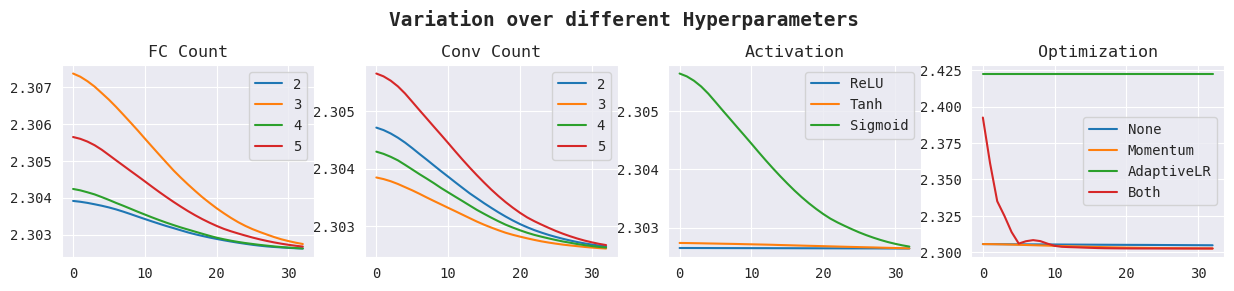

In [214]:
base_hyperparameter_selection = {
    'fc_count': [5],
    'conv_count': [5],
    'activations': [nn.Sigmoid],
    'optimizations': ["Momentum"],
}


def plot_hyperparameter_variation(title, name, values, ax):
    selection = base_hyperparameter_selection.copy()
    selection[name] = values
    ax.set_title(title)

    index = 0
    for fc_count, conv_count, activation, optimization \
            in itertools.product(selection['fc_count'], selection['conv_count'],
                                 selection['activations'], selection['optimizations']):
        key = ", ".join([str(fc_count), str(conv_count), activation.__name__, str(optimization)])
        label = values[index]
        if str(type(values[index])) == "<class 'type'>":
            label = label.__name__
        else:
            label = str(label)
        data = perm_history[key]["val_loss"]
        # if name == 'optimizations':
        #     ax.set_yscale('log')
        #     ax.set_ylim(2.3, 2.304)
        ax.plot(data, label=label)
        index += 1

    ax.legend()
    # Length normalization not required...
    # min_data_size = min([len(d) for d in data])
    # data = [d[::len(d) // min_data_size] for d in data]


fig, axs = plt.subplots(1, 4, figsize=(15, 2.5))
plot_hyperparameter_variation("FC Count", "fc_count", perm_fc_count, axs[0])
plot_hyperparameter_variation("Conv Count", "conv_count", perm_conv_count, axs[1])
plot_hyperparameter_variation("Activation", "activations", perm_activations, axs[2])
plot_hyperparameter_variation("Optimization", "optimizations", perm_optimizations, axs[3])
plt.suptitle('Variation over different Hyperparameters', **font_title, x=0.5, y=1.1)
plt.show()

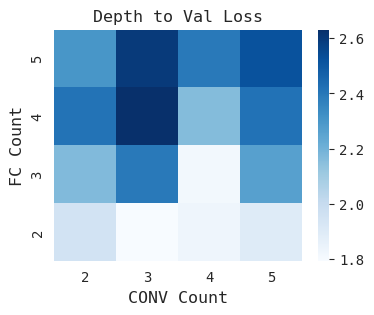

In [284]:
_ds_depth = np.zeros((len(perm_fc_count), len(perm_conv_count)))

for fc_count, conv_count, activation, optimization \
        in itertools.product(perm_fc_count, perm_conv_count, [nn.Tanh], ['Both']):
    # [nn.Sigmoid], ['Momentum']
    # [nn.Tanh], ['AdaptiveLR']
    # [nn.Tanh], ['Both']
    # [nn.Sigmoid], [None]
    key = ", ".join([str(fc_count), str(conv_count), activation.__name__, str(optimization)])
    _ds_depth[fc_count - 2, conv_count - 2] = perm_history[key]['train_loss'][-1]

plt.figure(figsize=sml_fig)
sns.heatmap(_ds_depth[::-1], cmap='Blues')
plt.yticks(.5 + np.arange(len(perm_fc_count)), map(str, reversed(perm_fc_count)))
plt.xticks(.5 + np.arange(len(perm_conv_count)), map(str, perm_conv_count))
# conclude_plot(None, y_label="FC Count", x_label="CONV Count", constrained=True)
plt.title("Depth to Val Loss")
plt.xlabel("CONV Count")
plt.ylabel("FC Count")
plt.show()

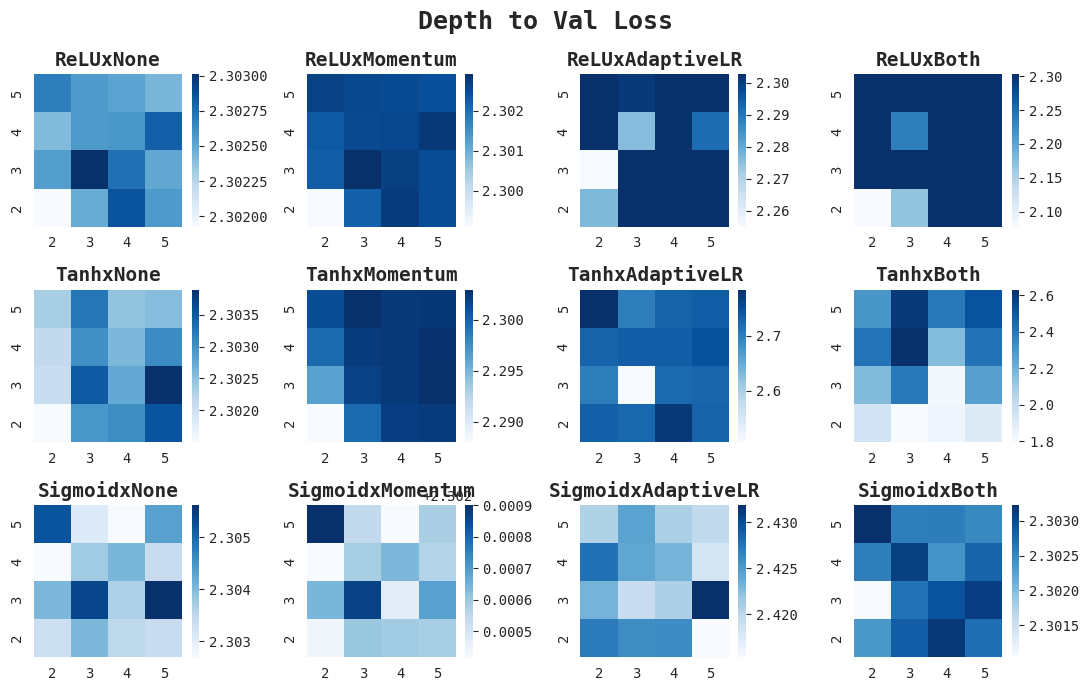

In [280]:
fig, axs = plt.subplots(len(perm_activations), len(perm_optimizations), figsize=(max_fig_width, 7))

for ax, (activation, optimization) in zip(axs.flatten(), itertools.product(perm_activations, perm_optimizations)):
    _ds_depth = np.zeros((len(perm_fc_count), len(perm_conv_count)))
    for fc_count, conv_count in itertools.product(perm_fc_count, perm_conv_count):
        key = ", ".join([str(fc_count), str(conv_count), activation.__name__, str(optimization)])
        _ds_depth[fc_count - 2, conv_count - 2] = perm_history[key]['train_loss'][-1]
    # _ds_depth_val_loss = _ds_depth_val_loss[:, ::-1]
    # _ds_depth[2, 3] = 0
    _ds_depth = _ds_depth[::-1]

    sns.heatmap(_ds_depth, cmap='Blues', ax=ax)
    # sns.heatmap(_ds_depth_val_loss, vmax=2.8, vmin=1.8, cmap='gist_ncar', ax=ax)
    # sns.heatmap(_ds_depth, vmax=1, vmin=0, cmap='gist_ncar', ax=ax)
    ax.set_yticks(.5 + np.arange(len(perm_fc_count)), map(str, reversed(perm_fc_count)))
    ax.set_xticks(.5 + np.arange(len(perm_conv_count)), map(str, perm_conv_count))
    annotate_plot(ax, f"{activation.__name__}x{optimization}")

conclude_plot("Depth to Val Loss", constrained=False)

In [88]:
_min = 100000
for fc_count, conv_count, activation, optimization \
        in itertools.product(perm_fc_count, perm_conv_count,
                             perm_activations, perm_optimizations):
    key = ", ".join([str(fc_count), str(conv_count), activation.__name__, str(optimization)])
    _min = min(_min, min(perm_history[key]['train_loss']))
print(_min)

1.784095048904419


In [100]:
max([x['train_acc'][-1] for x in perm_history.values()])

-0.00029754638671875

<BarContainer object of 10 artists>

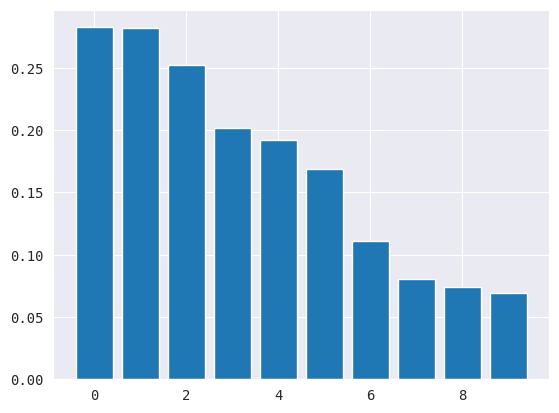

In [110]:
convergence_speeds = [(y[-1] - y[0]) for y in [x['train_acc'] for x in perm_history.values()]]
top_convergence_speeds = sorted(convergence_speeds, reverse=True)[:10]
plt.bar(range(len(top_convergence_speeds)), top_convergence_speeds)

<BarContainer object of 10 artists>

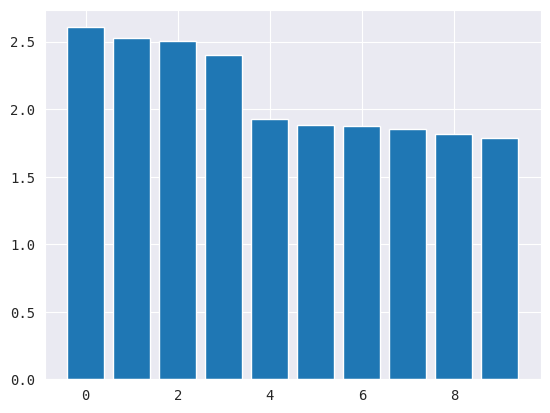

In [174]:
convergence_speeds = [np.polyfit(range(len(y)), np.log(y), 1)[1] for y in
                      [x['train_loss'] for x in perm_history.values()]]
top_convergence_speeds = sorted(convergence_speeds, reverse=True)[:10]
plt.bar(range(len(top_convergence_speeds)), top_convergence_speeds)

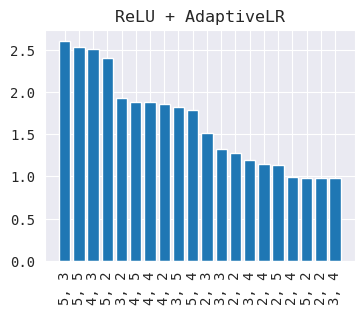

In [270]:
plt.figure(figsize=sml_fig)
convergence_speeds = [
    [np.polyfit(range(len(v)), np.log(v), 1)[1], k] for v, k in
    [[v['train_loss'], k] for k, v in perm_history.items()]
]
top_convergence_speeds, keys = zip(*sorted(convergence_speeds, reverse=True)[:20])
plt.bar(range(len(top_convergence_speeds)), top_convergence_speeds)
# plt.bar(range(len(top_convergence_speeds)), [np.sum([*map(int, k[:4].split(", "))]) for k in keys])
plt.xticks(range(len(top_convergence_speeds)), [k[:4] for k in keys])
plt.tick_params(axis='x', labelrotation=90)
plt.title("ReLU + AdaptiveLR")
plt.show()

[np.int64(15),
 np.int64(25),
 np.int64(12),
 np.int64(10),
 np.int64(6),
 np.int64(20),
 np.int64(16),
 np.int64(8),
 np.int64(15),
 np.int64(20),
 np.int64(6),
 np.int64(9),
 np.int64(4),
 np.int64(12),
 np.int64(8),
 np.int64(10),
 np.int64(8),
 np.int64(10),
 np.int64(4),
 np.int64(12)]

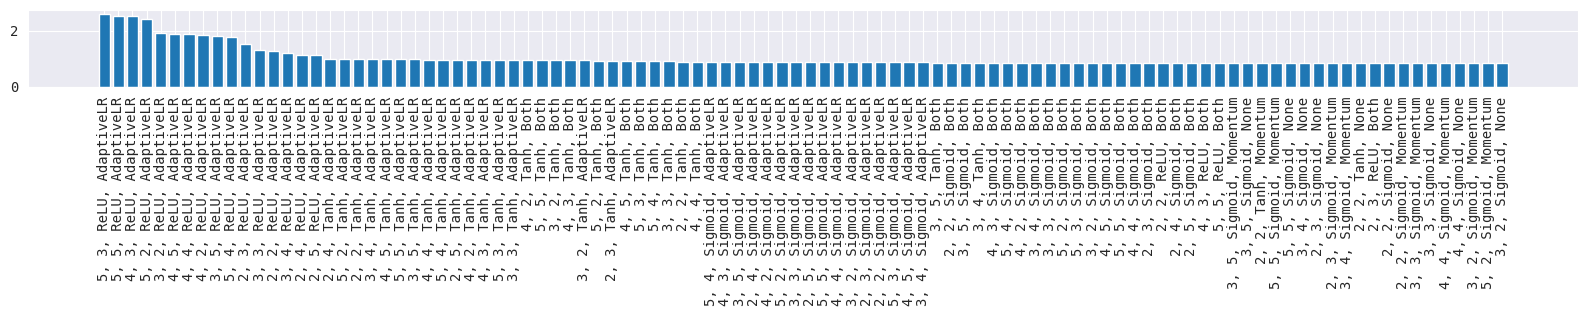

In [227]:
plt.figure(figsize=(20, 1))
convergence_speeds = [
    [np.polyfit(range(len(v)), np.log(v), 1)[1], k] for v, k in
    [[v['train_loss'], k] for k, v in perm_history.items()]
]
top_convergence_speeds, keys = zip(*sorted(convergence_speeds, reverse=True)[:100])
plt.bar(range(len(top_convergence_speeds)), top_convergence_speeds)
plt.xticks(range(len(top_convergence_speeds)), keys)
plt.tick_params(axis='x', labelrotation=90)

Text(0.5, 1.0, 'Mean Convergence Speed')

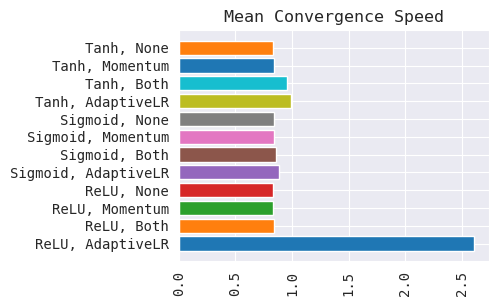

In [256]:
convergence_speeds = [
    [np.polyfit(range(len(v)), np.log(v), 1)[1], k] for v, k in
    [[v['train_loss'], k[6:]] for k, v in perm_history.items()]
]
convergence_speeds = pd.DataFrame(convergence_speeds, columns=['speed', 'key'])
# top_convergence_speeds, keys = zip(*sorted(convergence_speeds, reverse=True)[:100])
# plt.bar(range(len(top_convergence_speeds)), top_convergence_speeds)
# plt.xticks(range(len(top_convergence_speeds)), keys)
# plt.tick_params(axis='x', labelrotation=90)
ds_maxs = convergence_speeds.groupby('key')['speed'].max()
ds_means = convergence_speeds.groupby('key')['speed'].mean()

plt.figure(figsize=sml_fig)
for i, idx in enumerate(ds_means.index):
    plt.barh(i, ds_maxs[idx])
    # plt.barh(i, ds_means[idx])
plt.yticks(range(len(ds_means)), ds_means.index)
plt.tick_params(axis='x', labelrotation=90)
plt.title("Mean Convergence Speed")

<Axes: xlabel='key', ylabel='speed'>

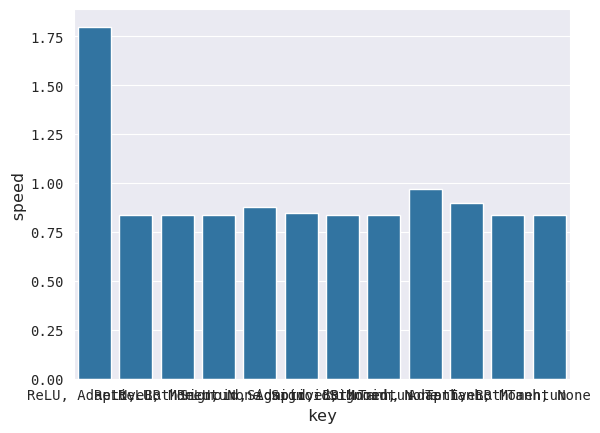

In [249]:
sns.barplot(ds_means.T)
